In [6]:
import matplotlib.pyplot as plt
import numpy as np
from pylab import *
from qutip import *
from numpy.linalg import inv

from scipy import optimize
import scipy
from numpy.linalg import inv
# from slab.dsfit import *
import timeit
import numpy.matlib
eq = 1.602/10**19
epsilon = 8.854/10**12
h = 6.636/10**34
hbar = h/2/pi
kb = 1.381/10**23
Tc = 1.2
delta = 1.764*kb*Tc
phi0 = h/2/eq
dielectric = 9.34*epsilon

from qutip.qip.operations import rx,ry
N_q = 3
N_r = 2

I36 = qutip.tensor(qutip.qeye(N_q),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
m1d = qutip.tensor(Qobj(np.array([[0,0,1],[0,0,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
p1d = qutip.tensor(Qobj(np.array([[0,0,0],[0,0,0],[1,0,0]]),dims=[[3],[3]]),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
m2d = qutip.tensor(qutip.qeye(N_q),Qobj(np.array([[0,0,1],[0,0,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
p2d = qutip.tensor(qutip.qeye(N_q),Qobj(np.array([[0,0,0],[0,0,0],[1,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
x1 = m1d+p1d
x2 = m2d+p2d

noterr1 = qutip.tensor(qutip.qeye(N_q)-ket('1',3)*bra('1',3),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
noterr2 = qutip.tensor(qutip.qeye(N_q),qutip.qeye(N_q)-ket('1',3)*bra('1',3),qutip.qeye(N_r),qutip.qeye(N_r))
z1 = qutip.tensor(qutip.destroy(N_q).dag()*qutip.destroy(N_q)-qeye(N_q),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
z2 = qutip.tensor(qutip.qeye(N_q),qutip.destroy(N_q).dag()*qutip.destroy(N_q)-qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
trackxp = 1/2*noterr1*noterr2*(I36+x1)*x2
trackzz = 1/2*noterr1*noterr2*(I36-x1*x2)*z1*z2

In [7]:
from matplotlib import cm
from qutip import settings
import matplotlib as mpl
# Adopted from the SciPy Cookbook.
def _blob(x, y, w, w_max, area, color_fn, ax=None):
    """
    Draws a square-shaped blob with the given area (< 1) at
    the given coordinates.
    """
    hs = np.sqrt(area) / 2
    xcorners = array([x - hs, x + hs, x + hs, x - hs])
    ycorners = array([y - hs, y - hs, y + hs, y + hs])

    if ax is not None:
        handle = ax
    else:
        handle = plt

    handle.fill(xcorners, ycorners,
             color=color_fn(w))


def _cb_labels(left_dims):
    """Creates plot labels for matrix elements in the computational basis.

    Parameters
    ----------
    left_dims : flat list of ints
        Dimensions of the left index of a density operator. E. g.
        [2, 3] for a qubit tensored with a qutrit.

    Returns
    -------
    left_labels, right_labels : lists of strings
        Labels for the left and right indices of a density operator
        (kets and bras, respectively).
    """
    # FIXME: assumes dims, such that we only need left_dims == dims[0].
    basis_labels = list(map(",".join, it.product(*[
        map(str, range(dim))
        for dim in left_dims
    ])))
    return [
        map(fmt.format, basis_labels) for fmt in
        (
            r"$|{}\rangle$",
            r"$\langle{}|$"
        )
    ]


# Adopted from the SciPy Cookbook.
def hinton1(rho, xlabels=None, ylabels=None, title=None, ax=None, cmap=None,
           label_top=True, color_style="scaled", colorbar=True, fixed_area=False, scale_max=1):
    """Draws a Hinton diagram for visualizing a density matrix or superoperator.

    Parameters
    ----------
    rho : qobj
        Input density matrix or superoperator.

    xlabels : list of strings or False
        list of x labels

    ylabels : list of strings or False
        list of y labels

    title : string
        title of the plot (optional)

    ax : a matplotlib axes instance
        The axes context in which the plot will be drawn.

    cmap : a matplotlib colormap instance
        Color map to use when plotting.

    label_top : bool
        If True, x-axis labels will be placed on top, otherwise
        they will appear below the plot.

    color_style : string
        Determines how colors are assigned to each square:

        -  If set to ``"scaled"`` (default), each color is chosen by
           passing the absolute value of the corresponding matrix
           element into `cmap` with the sign of the real part.
        -  If set to ``"threshold"``, each square is plotted as
           the maximum of `cmap` for the positive real part and as
           the minimum for the negative part of the matrix element;
           note that this generalizes `"threshold"` to complex numbers.
        -  If set to ``"phase"``, each color is chosen according to
           the angle of the corresponding matrix element.

    Returns
    -------
    fig, ax : tuple
        A tuple of the matplotlib figure and axes instances used to produce
        the figure.

    Raises
    ------
    ValueError
        Input argument is not a quantum object.

    Examples
    --------
    >>> import qutip
    >>>
    >>> dm = qutip.rand_dm(4)
    >>> fig, ax = qutip.hinton(dm)
    >>> fig.show()
    >>>
    >>> qutip.settings.colorblind_safe = True
    >>> fig, ax = qutip.hinton(dm, color_style="threshold")
    >>> fig.show()
    >>> qutip.settings.colorblind_safe = False
    >>>
    >>> fig, ax = qutip.hinton(dm, color_style="phase")
    >>> fig.show()
    """

    # Apply default colormaps.
    # TODO: abstract this away into something that makes default
    #       colormaps.
    cmap = (
        (cm.Greys_r if settings.colorblind_safe else cm.RdBu)
        if cmap is None else cmap
    )

    # Extract plotting data W from the input.
    if isinstance(rho, Qobj):
        if rho.isoper:
            W = rho.full()

            # Create default labels if none are given.
            if xlabels is None or ylabels is None:
                labels = _cb_labels(rho.dims[0])
                xlabels = xlabels if xlabels is not None else list(labels[0])
                ylabels = ylabels if ylabels is not None else list(labels[1])

        elif rho.isoperket:
            W = vector_to_operator(rho).full()
        elif rho.isoperbra:
            W = vector_to_operator(rho.dag()).full()
        elif rho.issuper:
            if not _isqubitdims(rho.dims):
                raise ValueError("Hinton plots of superoperators are "
                                 "currently only supported for qubits.")
            # Convert to a superoperator in the Pauli basis,
            # so that all the elements are real.
            sqobj = _super_to_superpauli(rho)
            nq = int(log2(sqobj.shape[0]) / 2)
            W = sqobj.full().T
            # Create default labels, too.
            if (xlabels is None) or (ylabels is None):
                labels = list(map("".join, it.product("IXYZ", repeat=nq)))
                xlabels = xlabels if xlabels is not None else labels
                ylabels = ylabels if ylabels is not None else labels

        else:
            raise ValueError(
                "Input quantum object must be an operator or superoperator."
            )

    else:
        W = rho

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    else:
        fig = None

    if not (xlabels or ylabels):
        ax.axis('off')
    if title:
        ax.set_title(title)

    ax.axis('equal')
    ax.set_frame_on(False)

    height, width = W.shape

    w_max = 1.25 * max(abs(np.diag(np.array(W))))
    # change color scale
    #################################
#     scale_max = 0.1111
    ##################################
    w_max=scale_max*1.25
    if w_max <= 0.0:
        w_max = 1.0

    # Set color_fn here.
    if color_style == "scaled":
        def color_fn(w):
            w = np.abs(w) * np.sign(np.real(w))
            return cmap(int((w + w_max) * 256 / (2 * w_max)))
    elif color_style == "threshold":
        def color_fn(w):
            w = np.real(w)
            return cmap(255 if w > 0 else 0)
    elif color_style == "phase":
        def color_fn(w):
            return cmap(int(255 * (np.angle(w) / 2 / np.pi + 0.5)))
    else:
        raise ValueError(
            "Unknown color style {} for Hinton diagrams.".format(color_style)
        )

    ax.fill(array([0, width, width, 0]), array([0, 0, height, height]),
            color=cmap(128))
    for x in range(width):
        for y in range(height):
            _x = x + 1
            _y = y + 1
            
            if fixed_area:
            ############################################### not changing area
                _blob(
                    _x - 0.5, height - _y + 0.5, W[x, y], w_max,
                    min(1, 1), color_fn=color_fn, ax=ax)
            else:
                ############################################# change area
                _blob(
                    _x - 0.5, height - _y + 0.5, W[x, y], w_max,
                    min(1, abs(W[x, y]) / w_max), color_fn=color_fn, ax=ax)

    # color axis sets the scale!
    ########################################################################################
    vmax = np.pi if color_style == "phase" else scale_max
    ###########################################################################################
    norm = mpl.colors.Normalize(-vmax, vmax)
    if colorbar:
        cax, kw = mpl.colorbar.make_axes(ax, shrink=0.75, pad=.1)
        mpl.colorbar.ColorbarBase(cax, norm=norm, cmap=cmap)

    xtics = 0.5 + np.arange(width)
    # x axis
    ax.xaxis.set_major_locator(plt.FixedLocator(xtics))
    if xlabels:
        nxlabels = len(xlabels)
        if nxlabels != len(xtics):
            raise ValueError(f"got {nxlabels} xlabels but needed {len(xtics)}")
        ax.set_xticklabels(xlabels)
        if label_top:
            ax.xaxis.tick_top()
    ax.tick_params(axis='x', labelsize=14)

    # y axis
    ytics = 0.5 + np.arange(height)
    ax.yaxis.set_major_locator(plt.FixedLocator(ytics))
    if ylabels:
        nylabels = len(ylabels)
        if nylabels != len(ytics):
            raise ValueError(f"got {nylabels} ylabels but needed {len(ytics)}")
        ax.set_yticklabels(list(reversed(ylabels)))
    ax.tick_params(axis='y', labelsize=14)

    return fig, ax

In [8]:
## Qutrit rotations
def Rge(phi, theta):
    mat = [[cos(theta/2), -exp(-1j*phi)*sin(theta/2), 0], 
           [exp(1j*phi)*sin(theta/2), cos(theta/2), 0], 
           [0, 0, 1]]
    return Qobj(mat)

def Ref(phi, theta):
    mat = [[1, 0, 0],
           [0, cos(theta/2), -exp(-1j*phi)*sin(theta/2)], 
           [0, exp(1j*phi)*sin(theta/2), cos(theta/2)]]
    return Qobj(mat)

In [9]:
def compute_expectation_vals(mesolve_result, operators):
    state_arr = mesolve_result.states
    expct_val_2d = []
    for op in operators:
        expct_val_2d.append(expect(op, state_arr))
        
    return np.array(expct_val_2d)
def find_optimal_th_iterative(dm, c0=1, c1=1, itr=2, steps=51):
    ''' Finds three phases to maximize fidelity '''
    # C0, C1 are the abs coeff of |L0> and |L1>
    
    def find_proj_along(dm, psi):
        return abs((psi.dag()*dm*psi)[0][0][0])  
    
    # Optimal phase th0 for |L0> = |gf> - exp(i th0)|fg>)
    start, stop = 0, 2*pi
    for ii in range(itr):
        th_arr = np.linspace(start,stop,steps)
        fid_arr = []
        for theta in th_arr:
            psi = (ket('02', dim=N_q) - exp(1j*theta)*ket('20', dim=N_q)).unit()
            fid_arr.append(find_proj_along(dm,psi))
        max_index = np.argmax(fid_arr)
        th0 = th_arr[max_index]
        if max_index + 1 == steps:
            start, stop = th_arr[max_index-1], 2*th_arr[max_index] - th_arr[max_index-1]
        else: start, stop = th_arr[max_index-1], th_arr[max_index+1]

    # Optimal phase th1 for |L1> = |gg> - exp(i th1)|ff>)
    start, stop = 0, 2*pi
    for ii in range(itr):
        th_arr = np.linspace(start,stop,steps)
        fid_arr = []
        for theta in th_arr:
            psi = (ket('00', dim=N_q) - exp(1j*theta)*ket('22', dim=N_q)).unit()
            fid_arr.append(find_proj_along(dm,psi))
        max_index = np.argmax(fid_arr)
        th1 = th_arr[max_index]
        if max_index + 1 == steps:
            start, stop = th_arr[max_index-1], 2*th_arr[max_index] - th_arr[max_index-1]
        else: start, stop = th_arr[max_index-1], th_arr[max_index+1]

    # Optimal phase th01 for |L0> + exp(i th01)|L1>)
    start, stop = 0, 2*pi
    for ii in range(itr):
        th_arr = np.linspace(start,stop,steps)
        fid_arr = []
        for theta in th_arr:
            psi = c0 * (ket('02', dim=N_q) - exp(1j*th0) * ket('20', dim=N_q))
            psi += c1 * exp(1j*theta) * (ket('00', dim=N_q) - exp(1j*th1) * ket('22', dim=N_q))
            psi = psi.unit()
            fid_arr.append(find_proj_along(dm,psi))
        max_index = np.argmax(fid_arr)
        th01 = th_arr[max_index]
        if max_index + 1 == steps:
            start, stop = th_arr[max_index-1], 2*th_arr[max_index] - th_arr[max_index-1]
        else: start, stop = th_arr[max_index-1], th_arr[max_index+1]
    
    return [th0, th1, th01], max(fid_arr)


def compute_optimal_ths_fids(dm_arr, c0=1, c1=1, itr=2, steps=51):
    ths_arr = []
    fid_max_arr = []
    for dm in dm_arr:
        dm = dm.ptrace([0,1])
        thetas, fid_max = find_optimal_th_iterative(dm, c0=c0, c1=c1, itr=itr, steps=steps)
        ths_arr.append(thetas)
        fid_max_arr.append(fid_max)
        
    return ths_arr, fid_max_arr

In [10]:
def stabilizationb(dark_param, tlist, psi0, options, barshown=True):

    
    N_q = 3
    N_r = 2
    n_th = dark_param['n_th']
    delta1 = dark_param['delta1']
    delta2 = dark_param['delta2']
    det1 = dark_param['det1']
    det2 = dark_param['det2']
    QRD = dark_param['QRD']
    Wr = dark_param['Wr']
    Wb = dark_param['Wb']
    Omega = dark_param['Omega']

    # Gamma_1phi_ge = dark_param['Gamma_1phi_ge']
    # Gamma_2phi_ge = dark_param['Gamma_2phi_ge']
    # Gamma_1phi_ef = dark_param['Gamma_1phi_ef']
    # Gamma_2phi_ef = dark_param['Gamma_2phi_ef']
    Gamma_1p = dark_param['Gamma_1p']
    
    Gamma_2p = dark_param['Gamma_2p']
    
    # Gamma_1p_ef = dark_param['Gamma_1p_ef']
    # Gamma_2p_ef = dark_param['Gamma_2p_ef']
    # Gamma_1p_gf = dark_param['Gamma_1p_gf']
    # Gamma_2p_gf = dark_param['Gamma_2p_gf']
    
    # Gamma_1h = dark_param['Gamma_1h']
    # Gamma_2h = dark_param['Gamma_2h']
    
    Gamma_1r = dark_param['Gamma_1r']
    Gamma_2r = dark_param['Gamma_2r']
    
    Id3 = qutip.qeye(N_q)
    Id2 = qutip.qeye(N_r)
    
    
    m1 = qutip.tensor(Qobj(np.array([[0,1,0],[0,0,sqrt(2)],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
    p1 = qutip.tensor(Qobj(np.array([[0,0,0],[1,0,0],[0,sqrt(2),0]]),dims=[[3],[3]]),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
    m2 = qutip.tensor(qutip.qeye(N_q),Qobj(np.array([[0,1,0],[0,0,sqrt(2)],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    p2 = qutip.tensor(qutip.qeye(N_q),Qobj(np.array([[0,0,0],[1,0,0],[0,sqrt(2),0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    
    decay_eg1 = qutip.tensor(Qobj(np.array([[0,1,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
    decay_fe1 = qutip.tensor(Qobj(np.array([[0,0,0],[0,0,sqrt(2)],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
    decay_eg2 = qutip.tensor(qutip.qeye(N_q),Qobj(np.array([[0,1,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    decay_fe2 = qutip.tensor(qutip.qeye(N_q),Qobj(np.array([[0,0,0],[0,0,sqrt(2)],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    
    z1_ge = qutip.tensor(Qobj(np.array([[0,0,0],[0,1,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
    z1_ef = qutip.tensor(Qobj(np.array([[0,0,0],[0,0,0],[0,0,sqrt(2)]]),dims=[[3],[3]]),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
    
    z2_ge = qutip.tensor(qutip.qeye(N_q),Qobj(np.array([[0,0,0],[0,1,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    z2_ef = qutip.tensor(qutip.qeye(N_q),Qobj(np.array([[0,0,0],[0,0,0],[0,0,sqrt(2)]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    
    m1_ge = qutip.tensor(Qobj(np.array([[0,1,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
    m2_ge = qutip.tensor(qutip.qeye(N_q),Qobj(np.array([[0,1,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    m1_ef = qutip.tensor(Qobj(np.array([[0,0,0],[0,0,sqrt(2)],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
    m2_ef = qutip.tensor(qutip.qeye(N_q),Qobj(np.array([[0,0,0],[0,0,sqrt(2)],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    
    m1_gf = qutip.tensor(Qobj(np.array([[0,0,1],[0,0,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
    m2_gf = qutip.tensor(qutip.qeye(N_q),Qobj(np.array([[0,0,1],[0,0,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    
    m1d = qutip.tensor(Qobj(np.array([[0,0,1],[0,0,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
    p1d = qutip.tensor(Qobj(np.array([[0,0,0],[0,0,0],[1,0,0]]),dims=[[3],[3]]),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
    m2d = qutip.tensor(qutip.qeye(N_q),Qobj(np.array([[0,0,1],[0,0,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    p2d = qutip.tensor(qutip.qeye(N_q),Qobj(np.array([[0,0,0],[0,0,0],[1,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    
    x1d = m1d+p1d
    x2d = m2d+p2d
    z1 = qutip.tensor(Qobj(np.array([[-1,0,0],[0,0,0],[0,0,1]]),dims=[[3],[3]]),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
    zp1 = qutip.tensor(Qobj(np.array([[-1,0,0],[0,1,0],[0,0,1]]),dims=[[3],[3]]),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
    z2 = qutip.tensor(qutip.qeye(N_q),Qobj(np.array([[-1,0,0],[0,0,0],[0,0,1]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    zp2 = qutip.tensor(qutip.qeye(N_q),Qobj(np.array([[-1,0,0],[0,1,0],[0,0,1]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    zs1 = qutip.tensor(qutip.qeye(N_q),qutip.qeye(N_q),-sigmaz(),qutip.qeye(N_r))
    zs2 = qutip.tensor(qutip.qeye(N_q),qutip.qeye(N_q),qutip.qeye(N_r),-sigmaz())
    
    I36 = qutip.tensor(qutip.qeye(N_q),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
    
    err1 = qutip.tensor(ket('1',3)*bra('1',3),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
    err2 = qutip.tensor(qutip.qeye(N_q),ket('1',3)*bra('1',3),qutip.qeye(N_r),qutip.qeye(N_r))
    noterr1 = qutip.tensor(qutip.qeye(N_q)-ket('1',3)*bra('1',3),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
    noterr2 = qutip.tensor(qutip.qeye(N_q),qutip.qeye(N_q)-ket('1',3)*bra('1',3),qutip.qeye(N_r),qutip.qeye(N_r))

    az1 = qutip.tensor(qutip.destroy(N_q).dag()*qutip.destroy(N_q)-qeye(N_q),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
    az2 = qutip.tensor(qutip.qeye(N_q),qutip.destroy(N_q).dag()*qutip.destroy(N_q)-qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
    azr1 = qutip.tensor(qutip.qeye(N_q),qutip.qeye(N_q),qutip.destroy(N_r).dag()*qutip.destroy(N_r)-qeye(N_r),qutip.qeye(N_r))
    azr2 = qutip.tensor(qutip.qeye(N_q),qutip.qeye(N_q),qutip.qeye(N_r),qutip.destroy(N_r).dag()*qutip.destroy(N_r)-qeye(N_r))
    m1d = qutip.tensor(Qobj(np.array([[0,0,1],[0,0,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
    p1d = qutip.tensor(Qobj(np.array([[0,0,0],[0,0,0],[1,0,0]]),dims=[[3],[3]]),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
    m2d = qutip.tensor(qutip.qeye(N_q),Qobj(np.array([[0,0,1],[0,0,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    p2d = qutip.tensor(qutip.qeye(N_q),Qobj(np.array([[0,0,0],[0,0,0],[1,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    fz1 = qutip.tensor(Qobj(np.array([[0,0,0],[0,1,0],[0,0,2]]),dims=[[3],[3]]),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
    fz2 = qutip.tensor(qutip.qeye(N_q),Qobj(np.array([[0,0,0],[0,1,0],[0,0,2]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    
    
    ms1 = qutip.tensor(qutip.qeye(N_q),qutip.qeye(N_q),Qobj(np.array([[0,1],[0,0]]),dims=[[2],[2]]),qutip.qeye(N_r))
    ms2 = qutip.tensor(qutip.qeye(N_q),qutip.qeye(N_q),qutip.qeye(N_r),Qobj(np.array([[0,1],[0,0]]),dims=[[2],[2]]))
    
    ps1 = qutip.tensor(qutip.qeye(N_q),qutip.qeye(N_q),Qobj(np.array([[0,0],[1,0]]),dims=[[2],[2]]),qutip.qeye(N_r))
    ps2 = qutip.tensor(qutip.qeye(N_q),qutip.qeye(N_q),qutip.qeye(N_r),Qobj(np.array([[0,0],[1,0]]),dims=[[2],[2]]))
    
    zs1 = qutip.tensor(qutip.qeye(N_q),qutip.qeye(N_q),Qobj(np.array([[-1,0],[0,1]]),dims=[[2],[2]]),qutip.qeye(N_r))
    zs2 = qutip.tensor(qutip.qeye(N_q),qutip.qeye(N_q),qutip.qeye(N_r),Qobj(np.array([[-1,0],[0,1]]),dims=[[2],[2]]))
    
    
    z1=az1
    z2=az2
    
    x1 = m1d+p1d
    x2 = m2d+p2d
    
    eg1 = qutip.tensor(Qobj(np.array([[0,1,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
    ge1 = eg1.dag()
    eg2 = qutip.tensor(qutip.qeye(N_q),Qobj(np.array([[0,1,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    ge2 = eg2.dag()
    fe1 = qutip.tensor(Qobj(np.array([[0,0,0],[0,0,1],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
    ef1 = fe1.dag()
    fe2 = qutip.tensor(qutip.qeye(N_q),Qobj(np.array([[0,0,0],[0,0,1],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    ef2 = fe2.dag()
    
    ee0ef1 = qutip.tensor(Qobj(np.array([[0,0,0],[0,1,0],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[0,0,1],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,1],[0,0]]),dims=[[2],[2]]),qutip.qeye(N_r))
    ee0fe1 = qutip.tensor(Qobj(np.array([[0,0,0],[0,0,1],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[0,1,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),Qobj(np.array([[0,1],[0,0]]),dims=[[2],[2]]))

    H0 = delta1/2*err1*noterr2+delta2/2*err2*noterr1+1/2*(delta1/2*(zs1+I36)+delta2/2*(zs2+I36))
    H1 = (Omega*(p1*ps1-ee0fe1)+Omega*(m1*ms1-ee0fe1.dag())+Omega*(p2*ps2-ee0ef1)+Omega*(m2*ms2-ee0ef1.dag()))+QRD/2*(fz1*(zs1+I36)+fz2*(zs2+I36))
#     print(H0+H1)

    # define the time-dependence of the hamiltonian using the list-string format
    args = {'det1':det1,'det2':det2,'Wr':Wr,'Wb':Wb}
    Ht = [H0+H1,[-Wb*eg1*eg2,'exp(-1j*2*pi*det2*t)'], \
                [-Wb*ge1*ge2,'exp(1j*2*pi*det2*t)'], \
                [-Wb*fe1*fe2,'exp(1j*2*pi*det2*t)'], \
                [-Wb*ef1*ef2,'exp(-1j*2*pi*det2*t)'], \
                [-Wr*ef1*eg2,'exp(1j*2*pi*det1*t)'], \
                [-Wr*fe1*ge2,'exp(-1j*2*pi*det1*t)'], \
                [-Wr*eg1*ef2,'exp(1j*2*pi*det1*t)'], \
                [-Wr*ge1*fe2,'exp(-1j*2*pi*det1*t)']]
    
    projs = (zs1-I36)/2*(zs2-I36)/2
    projcw0 = 1/4*noterr1*noterr2*(I36+az1*az2)*(I36-x1*x2)
    projcw1 = 1/4*noterr1*noterr2*(I36-az1*az2)*(I36-x1*x2)
    randomstate = qutip.tensor(Qobj(np.array(np.random.rand(3,3)),dims=[[3],[3]]),Qobj(np.array(np.random.rand(3,3)),dims=[[3],[3]]),
                               Qobj(np.array(np.random.rand(2,2)),dims=[[2],[2]]),Qobj(np.array(np.random.rand(2,2)),dims=[[2],[2]]))
    
  
    projcwxp = 1/4*noterr1*noterr2*(I36-x1)*(I36+x2)
    projcwxm = 1/4*noterr1*noterr2*(I36+x1)*(I36-x2)
    cwxp = (projcwxp*projs*randomstate).unit()
    cwxm = (projcwxm*projs*randomstate).unit()
    
    trackxp = 1/2*noterr1*noterr2*(I36-x1)*x2
    trackxm = -1/2*noterr1*noterr2*(I36+x1)*x2
    trackzz = 1/2*noterr1*noterr2*(I36-x1*x2)*z1*z2
    
#     print(trackxp)


    result1 = []        
    c_ops = []
    if Gamma_1p > 0:
        c_ops.append(np.sqrt(Gamma_1p) * decay_eg1)
        c_ops.append(np.sqrt(Gamma_1p) * decay_fe1)
        
#     if Gamma_1p_ef > 0:
#         c_ops.append(np.sqrt(Gamma_1p_ef) * m1_ef)
        
#     if Gamma_1p_gf > 0:
#         c_ops.append(np.sqrt(Gamma_1p_gf) * m1_gf)
    
#     if Gamma_1h > 0:
#         c_ops.append(np.sqrt(Gamma_1h) * p1)
        
#     if Gamma_2h > 0:
#         c_ops.append(np.sqrt(Gamma_2h) * p2)
        
#     if Gamma_1phi_ge > 0:
#         c_ops.append(np.sqrt(Gamma_1phi_ge) * z1_ge)
        
#     if Gamma_1phi_ef > 0:
#         c_ops.append(np.sqrt(Gamma_1phi_ef) * z1_ef)
    
    # if Gamma_2p > 0:
    #     c_ops.append(np.sqrt(Gamma_2p) * m2_ge)
    
    # if Gamma_2p_ef > 0:
    #     c_ops.append(np.sqrt(Gamma_2p_ef) * m2_ef)
        
    if Gamma_2p > 0:
        c_ops.append(np.sqrt(Gamma_2p) * decay_eg2)
        c_ops.append(np.sqrt(Gamma_2p) * decay_fe2)
        
    # if Gamma_2phi_ge > 0:
    #     c_ops.append(np.sqrt(Gamma_2phi_ge) * z2_ge)
        
    # if Gamma_2phi_ef > 0:
    #     c_ops.append(np.sqrt(Gamma_2phi_ef) * z2_ef)
        
    if Gamma_1r > 0:
        c_ops.append(np.sqrt(Gamma_1r) * ms1)
        
    if Gamma_2r > 0:
        c_ops.append(np.sqrt(Gamma_2r) * ms2)
    
    rate = Gamma_1r * n_th
    if rate > 0.0:
        c_ops.append(np.sqrt(rate) * ps1)  # excitation operators
        
    rate = Gamma_2r * n_th
    if rate > 0.0:
        c_ops.append(np.sqrt(rate) * ps2)  # excitation operators

    print('Calculating T_1p')
    if barshown:
        output1 = qutip.mesolve(Ht, psi0, tlist, c_ops, [], args, options=options, progress_bar=True)
    else:
        output1 = qutip.mesolve(Ht, psi0, tlist, c_ops, [az1, az2], args, options=options)
    result1 = output1   
    
    return c_ops, result1

In [11]:
def stabilizationc(dark_param, tlist, psi0, options, barshown=True):

    
    N_q = 3
    N_r = 2
    n_th = dark_param['n_th']
    delta1 = dark_param['delta1']
    delta2 = dark_param['delta2']
    det1 = dark_param['det1']
    det2 = dark_param['det2']
    QRD = dark_param['QRD']
    Wr = dark_param['Wr']
    Wb = dark_param['Wb']
    Omega = dark_param['Omega']

    # Gamma_1phi_ge = dark_param['Gamma_1phi_ge']
    # Gamma_2phi_ge = dark_param['Gamma_2phi_ge']
    # Gamma_1phi_ef = dark_param['Gamma_1phi_ef']
    # Gamma_2phi_ef = dark_param['Gamma_2phi_ef']
    Gamma_1p = dark_param['Gamma_1p']
    
    Gamma_2p = dark_param['Gamma_2p']
    
    # Gamma_1p_ef = dark_param['Gamma_1p_ef']
    # Gamma_2p_ef = dark_param['Gamma_2p_ef']
    # Gamma_1p_gf = dark_param['Gamma_1p_gf']
    # Gamma_2p_gf = dark_param['Gamma_2p_gf']
    
    # Gamma_1h = dark_param['Gamma_1h']
    # Gamma_2h = dark_param['Gamma_2h']
    
    Gamma_1r = dark_param['Gamma_1r']
    Gamma_2r = dark_param['Gamma_2r']
    
    Id3 = qutip.qeye(N_q)
    Id2 = qutip.qeye(N_r)
    
    
    m1 = qutip.tensor(Qobj(np.array([[0,1,0],[0,0,sqrt(2)],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
    p1 = qutip.tensor(Qobj(np.array([[0,0,0],[1,0,0],[0,sqrt(2),0]]),dims=[[3],[3]]),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
    m2 = qutip.tensor(qutip.qeye(N_q),Qobj(np.array([[0,1,0],[0,0,sqrt(2)],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    p2 = qutip.tensor(qutip.qeye(N_q),Qobj(np.array([[0,0,0],[1,0,0],[0,sqrt(2),0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    
    decay_eg1 = qutip.tensor(Qobj(np.array([[0,1,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
    decay_fe1 = qutip.tensor(Qobj(np.array([[0,0,0],[0,0,sqrt(2)],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
    decay_eg2 = qutip.tensor(qutip.qeye(N_q),Qobj(np.array([[0,1,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    decay_fe2 = qutip.tensor(qutip.qeye(N_q),Qobj(np.array([[0,0,0],[0,0,sqrt(2)],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    
    ms1 = qutip.tensor(qutip.qeye(N_q),qutip.qeye(N_q),Qobj(np.array([[0,1],[0,0]]),dims=[[2],[2]]),qutip.qeye(N_r))
    ms2 = qutip.tensor(qutip.qeye(N_q),qutip.qeye(N_q),qutip.qeye(N_r),Qobj(np.array([[0,1],[0,0]]),dims=[[2],[2]]))
    
    ps1 = qutip.tensor(qutip.qeye(N_q),qutip.qeye(N_q),Qobj(np.array([[0,0],[1,0]]),dims=[[2],[2]]),qutip.qeye(N_r))
    ps2 = qutip.tensor(qutip.qeye(N_q),qutip.qeye(N_q),qutip.qeye(N_r),Qobj(np.array([[0,0],[1,0]]),dims=[[2],[2]]))
    
    Pgg = qutip.tensor(Qobj(np.array([[1,0,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[1,0,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    Pge = qutip.tensor(Qobj(np.array([[1,0,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[0,1,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    Pgf = qutip.tensor(Qobj(np.array([[1,0,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[0,0,0],[0,0,1]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    Peg = qutip.tensor(Qobj(np.array([[0,0,0],[0,1,0],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[1,0,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    Pee = qutip.tensor(Qobj(np.array([[0,0,0],[0,1,0],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[0,1,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    Pef = qutip.tensor(Qobj(np.array([[0,0,0],[0,1,0],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[0,0,0],[0,0,1]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    Pfg = qutip.tensor(Qobj(np.array([[0,0,0],[0,0,0],[0,0,1]]),dims=[[3],[3]]),Qobj(np.array([[1,0,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    Pfe = qutip.tensor(Qobj(np.array([[0,0,0],[0,0,0],[0,0,1]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[0,1,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    Pff = qutip.tensor(Qobj(np.array([[0,0,0],[0,0,0],[0,0,1]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[0,0,0],[0,0,1]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    
    eegf = qutip.tensor(Qobj(np.array([[0,0,0],[1,0,0],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[0,0,1],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    eefg = qutip.tensor(Qobj(np.array([[0,0,0],[0,0,1],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[1,0,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    eegg = qutip.tensor(Qobj(np.array([[0,0,0],[1,0,0],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[1,0,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    eeff = qutip.tensor(Qobj(np.array([[0,0,0],[0,0,1],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[0,0,1],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    
    egfg01 = qutip.tensor(Qobj(np.array([[0,0,0],[0,0,1],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[1,0,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,1],[0,0]]),dims=[[2],[2]]),qutip.qeye(N_r))
    efff01 = qutip.tensor(Qobj(np.array([[0,0,0],[0,0,1],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[0,0,0],[0,0,1]]),dims=[[3],[3]]),Qobj(np.array([[0,1],[0,0]]),dims=[[2],[2]]),qutip.qeye(N_r))
    
    gegf01 = qutip.tensor(Qobj(np.array([[1,0,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[0,0,1],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),Qobj(np.array([[0,1],[0,0]]),dims=[[2],[2]]))
    feff01 = qutip.tensor(Qobj(np.array([[0,0,0],[0,0,0],[0,0,1]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[0,0,1],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),Qobj(np.array([[0,1],[0,0]]),dims=[[2],[2]]))
    
    Hqq = Wr/2*(eegf+eefg)+Wb/2*(eegg+eeff)
    Hqq += Hqq.dag()
    Hqr = Omega/2*(egfg01+efff01+gegf01+feff01)
    Hqr += Hqr.dag()
    H0 = -delta1/2*(Peg+Pef)-delta2/2*(Pge+Pfe)-det1*(Pgf+Pfg+Pge+Peg)-det2*(Pgg+Pff+Pef+Pfe)+Hqq+Hqr-delta1/2*(ps1*ms1)-delta2/2*(ps2*ms2)

    # define the time-dependence of the hamiltonian using the list-string format
    args = {}
    Ht = H0
    
    # dims = [N_q,N_q,N_r,N_r]
    # psi00 = ket('1000',dim=dims)
    # psi0 = ket('1200',dim=dims)
    # psi00 = psi00.unit()
    # print(Hqr*psi00)

    result1 = []        
    c_ops = []
    if Gamma_1p > 0:
        c_ops.append(np.sqrt(Gamma_1p) * decay_eg1)
        c_ops.append(np.sqrt(Gamma_1p) * decay_fe1)
        
    if Gamma_2p > 0:
        c_ops.append(np.sqrt(Gamma_2p) * decay_eg2)
        c_ops.append(np.sqrt(Gamma_2p) * decay_fe2)
        
    if Gamma_1r > 0:
        c_ops.append(np.sqrt(Gamma_1r) * ms1)
        
    if Gamma_2r > 0:
        c_ops.append(np.sqrt(Gamma_2r) * ms2)
    
#     rate = Gamma_1r * n_th
#     if rate > 0.0:
#         c_ops.append(np.sqrt(rate) * ps1)  # excitation operators
        
#     rate = Gamma_2r * n_th
#     if rate > 0.0:
#         c_ops.append(np.sqrt(rate) * ps2)  # excitation operators

    print('Calculating T_1p')
    if barshown:
        output1 = qutip.mesolve(Ht, psi0, tlist, c_ops, [], args, options=options, progress_bar=True)
    else:
        output1 = qutip.mesolve(Ht, psi0, tlist, c_ops, [az1, az2], args, options=options)
    result1 = output1   
    
    return c_ops, result1

In [61]:
def stabilizationd(dark_param, tlist, psi0, options, barshown=True):

    
    N_q = 3
    N_r = 2
    n_th = dark_param['n_th']
    delta1 = dark_param['delta1']
    delta2 = dark_param['delta2']
    det1 = dark_param['det1']
    det2 = dark_param['det2']
    QRD = dark_param['QRD']
    Wr = dark_param['Wr']
    Wb = dark_param['Wb']
    Omega = dark_param['Omega']

    # Gamma_1phi_ge = dark_param['Gamma_1phi_ge']
    # Gamma_2phi_ge = dark_param['Gamma_2phi_ge']
    # Gamma_1phi_ef = dark_param['Gamma_1phi_ef']
    # Gamma_2phi_ef = dark_param['Gamma_2phi_ef']
    Gamma_1p = dark_param['Gamma_1p']
    
    Gamma_2p = dark_param['Gamma_2p']
    
    # Gamma_1p_ef = dark_param['Gamma_1p_ef']
    # Gamma_2p_ef = dark_param['Gamma_2p_ef']
    # Gamma_1p_gf = dark_param['Gamma_1p_gf']
    # Gamma_2p_gf = dark_param['Gamma_2p_gf']
    
    # Gamma_1h = dark_param['Gamma_1h']
    # Gamma_2h = dark_param['Gamma_2h']
    
    Gamma_1r = dark_param['Gamma_1r']
    Gamma_2r = dark_param['Gamma_2r']
    
    Id3 = qutip.qeye(N_q)
    Id2 = qutip.qeye(N_r)
    
    
    m1 = qutip.tensor(Qobj(np.array([[0,1,0],[0,0,sqrt(2)],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
    p1 = qutip.tensor(Qobj(np.array([[0,0,0],[1,0,0],[0,sqrt(2),0]]),dims=[[3],[3]]),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
    m2 = qutip.tensor(qutip.qeye(N_q),Qobj(np.array([[0,1,0],[0,0,sqrt(2)],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    p2 = qutip.tensor(qutip.qeye(N_q),Qobj(np.array([[0,0,0],[1,0,0],[0,sqrt(2),0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    
    decay_eg1 = qutip.tensor(Qobj(np.array([[0,1,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
    decay_fe1 = qutip.tensor(Qobj(np.array([[0,0,0],[0,0,sqrt(2)],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
    decay_eg2 = qutip.tensor(qutip.qeye(N_q),Qobj(np.array([[0,1,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    decay_fe2 = qutip.tensor(qutip.qeye(N_q),Qobj(np.array([[0,0,0],[0,0,sqrt(2)],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    
    ms1 = qutip.tensor(qutip.qeye(N_q),qutip.qeye(N_q),Qobj(np.array([[0,1],[0,0]]),dims=[[2],[2]]),qutip.qeye(N_r))
    ms2 = qutip.tensor(qutip.qeye(N_q),qutip.qeye(N_q),qutip.qeye(N_r),Qobj(np.array([[0,1],[0,0]]),dims=[[2],[2]]))
    
    ps1 = qutip.tensor(qutip.qeye(N_q),qutip.qeye(N_q),Qobj(np.array([[0,0],[1,0]]),dims=[[2],[2]]),qutip.qeye(N_r))
    ps2 = qutip.tensor(qutip.qeye(N_q),qutip.qeye(N_q),qutip.qeye(N_r),Qobj(np.array([[0,0],[1,0]]),dims=[[2],[2]]))
    
    Pgg = qutip.tensor(Qobj(np.array([[1,0,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[1,0,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    Pge = qutip.tensor(Qobj(np.array([[1,0,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[0,1,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    Pgf = qutip.tensor(Qobj(np.array([[1,0,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[0,0,0],[0,0,1]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    Peg = qutip.tensor(Qobj(np.array([[0,0,0],[0,1,0],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[1,0,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    Pee = qutip.tensor(Qobj(np.array([[0,0,0],[0,1,0],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[0,1,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    Pef = qutip.tensor(Qobj(np.array([[0,0,0],[0,1,0],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[0,0,0],[0,0,1]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    Pfg = qutip.tensor(Qobj(np.array([[0,0,0],[0,0,0],[0,0,1]]),dims=[[3],[3]]),Qobj(np.array([[1,0,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    Pfe = qutip.tensor(Qobj(np.array([[0,0,0],[0,0,0],[0,0,1]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[0,1,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    Pff = qutip.tensor(Qobj(np.array([[0,0,0],[0,0,0],[0,0,1]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[0,0,0],[0,0,1]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    
    eegf = qutip.tensor(Qobj(np.array([[0,0,0],[1,0,0],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[0,0,1],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    eefg = qutip.tensor(Qobj(np.array([[0,0,0],[0,0,1],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[1,0,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    eegg = qutip.tensor(Qobj(np.array([[0,0,0],[1,0,0],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[1,0,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    eeff = qutip.tensor(Qobj(np.array([[0,0,0],[0,0,1],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[0,0,1],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
    
    egfg01 = qutip.tensor(Qobj(np.array([[0,0,0],[0,0,1],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[1,0,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,1],[0,0]]),dims=[[2],[2]]),qutip.qeye(N_r))
    efff01 = qutip.tensor(Qobj(np.array([[0,0,0],[0,0,1],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[0,0,0],[0,0,1]]),dims=[[3],[3]]),Qobj(np.array([[0,1],[0,0]]),dims=[[2],[2]]),qutip.qeye(N_r))
    
    gegf01 = qutip.tensor(Qobj(np.array([[1,0,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[0,0,1],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),Qobj(np.array([[0,1],[0,0]]),dims=[[2],[2]]))
    feff01 = qutip.tensor(Qobj(np.array([[0,0,0],[0,0,0],[0,0,1]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[0,0,1],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),Qobj(np.array([[0,1],[0,0]]),dims=[[2],[2]]))
    
    Hqq = Wr/2*(eegf+eefg)+Wb/2*(eegg+eeff)
    Hqq += Hqq.dag()
    Hqr = Omega/2*(egfg01+efff01+gegf01+feff01)
    Hqr += Hqr.dag()
    H0 = -delta1/2*(Peg+Pef)-delta2/2*(Pge+Pfe)-det1*(Pgf+Pfg+Pge+Peg)-det2*(Pgg+Pff+Pef+Pfe)+Hqq+Hqr-delta1/2*(ps1*ms1)-delta2/2*(ps2*ms2)

    # define the time-dependence of the hamiltonian using the list-string format
    args = {}
    Ht = H0
    
    # dims = [N_q,N_q,N_r,N_r]
    # psi00 = ket('1000',dim=dims)
    # psi0 = ket('1200',dim=dims)
    # psi00 = psi00.unit()
    # print(Hqr*psi00)

    result1 = []        
    c_ops = []
    if Gamma_1p > 0:
        # c_ops.append(np.sqrt(Gamma_1p) * decay_eg1)
        c_ops.append(np.sqrt(Gamma_1p) * decay_fe1)
        
    if Gamma_2p > 0:
        # c_ops.append(np.sqrt(Gamma_2p) * decay_eg2)
        c_ops.append(np.sqrt(Gamma_2p) * decay_fe2)
        
    if Gamma_1r > 0:
        c_ops.append(np.sqrt(Gamma_1r) * ms1)
        
    if Gamma_2r > 0:
        c_ops.append(np.sqrt(Gamma_2r) * ms2)
    
#     rate = Gamma_1r * n_th
#     if rate > 0.0:
#         c_ops.append(np.sqrt(rate) * ps1)  # excitation operators
        
#     rate = Gamma_2r * n_th
#     if rate > 0.0:
#         c_ops.append(np.sqrt(rate) * ps2)  # excitation operators

    print('Calculating T_1p')
    if barshown:
        output1 = qutip.mesolve(Ht, psi0, tlist, c_ops, [], args, options=options, progress_bar=True)
    else:
        output1 = qutip.mesolve(Ht, psi0, tlist, c_ops, [az1, az2], args, options=options)
    result1 = output1   
    
    return c_ops, result1

In [63]:


dark_param = circuit_param 
N_q = 3
N_r = 2
n_th = dark_param['n_th']
delta1 = dark_param['delta1']
delta2 = dark_param['delta2']
det1 = dark_param['det1']
det2 = dark_param['det2']
QRD = dark_param['QRD']
Wr = dark_param['Wr']
Wb = dark_param['Wb']
Omega = dark_param['Omega']

# Gamma_1phi_ge = dark_param['Gamma_1phi_ge']
# Gamma_2phi_ge = dark_param['Gamma_2phi_ge']
# Gamma_1phi_ef = dark_param['Gamma_1phi_ef']
# Gamma_2phi_ef = dark_param['Gamma_2phi_ef']
Gamma_1p = dark_param['Gamma_1p']

Gamma_2p = dark_param['Gamma_2p']

# Gamma_1p_ef = dark_param['Gamma_1p_ef']
# Gamma_2p_ef = dark_param['Gamma_2p_ef']
# Gamma_1p_gf = dark_param['Gamma_1p_gf']
# Gamma_2p_gf = dark_param['Gamma_2p_gf']

# Gamma_1h = dark_param['Gamma_1h']
# Gamma_2h = dark_param['Gamma_2h']

Gamma_1r = dark_param['Gamma_1r']
Gamma_2r = dark_param['Gamma_2r']

Id3 = qutip.qeye(N_q)
Id2 = qutip.qeye(N_r)


m1 = qutip.tensor(Qobj(np.array([[0,1,0],[0,0,sqrt(2)],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
p1 = qutip.tensor(Qobj(np.array([[0,0,0],[1,0,0],[0,sqrt(2),0]]),dims=[[3],[3]]),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
m2 = qutip.tensor(qutip.qeye(N_q),Qobj(np.array([[0,1,0],[0,0,sqrt(2)],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
p2 = qutip.tensor(qutip.qeye(N_q),Qobj(np.array([[0,0,0],[1,0,0],[0,sqrt(2),0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))

decay_eg1 = qutip.tensor(Qobj(np.array([[0,1,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
decay_fe1 = qutip.tensor(Qobj(np.array([[0,0,0],[0,0,sqrt(2)],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_q),qutip.qeye(N_r),qutip.qeye(N_r))
decay_eg2 = qutip.tensor(qutip.qeye(N_q),Qobj(np.array([[0,1,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
decay_fe2 = qutip.tensor(qutip.qeye(N_q),Qobj(np.array([[0,0,0],[0,0,sqrt(2)],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))

ms1 = qutip.tensor(qutip.qeye(N_q),qutip.qeye(N_q),Qobj(np.array([[0,1],[0,0]]),dims=[[2],[2]]),qutip.qeye(N_r))
ms2 = qutip.tensor(qutip.qeye(N_q),qutip.qeye(N_q),qutip.qeye(N_r),Qobj(np.array([[0,1],[0,0]]),dims=[[2],[2]]))

ps1 = qutip.tensor(qutip.qeye(N_q),qutip.qeye(N_q),Qobj(np.array([[0,0],[1,0]]),dims=[[2],[2]]),qutip.qeye(N_r))
ps2 = qutip.tensor(qutip.qeye(N_q),qutip.qeye(N_q),qutip.qeye(N_r),Qobj(np.array([[0,0],[1,0]]),dims=[[2],[2]]))

Pgg = qutip.tensor(Qobj(np.array([[1,0,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[1,0,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
Pge = qutip.tensor(Qobj(np.array([[1,0,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[0,1,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
Pgf = qutip.tensor(Qobj(np.array([[1,0,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[0,0,0],[0,0,1]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
Peg = qutip.tensor(Qobj(np.array([[0,0,0],[0,1,0],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[1,0,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
Pee = qutip.tensor(Qobj(np.array([[0,0,0],[0,1,0],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[0,1,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
Pef = qutip.tensor(Qobj(np.array([[0,0,0],[0,1,0],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[0,0,0],[0,0,1]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
Pfg = qutip.tensor(Qobj(np.array([[0,0,0],[0,0,0],[0,0,1]]),dims=[[3],[3]]),Qobj(np.array([[1,0,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
Pfe = qutip.tensor(Qobj(np.array([[0,0,0],[0,0,0],[0,0,1]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[0,1,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
Pff = qutip.tensor(Qobj(np.array([[0,0,0],[0,0,0],[0,0,1]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[0,0,0],[0,0,1]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))

eegf = qutip.tensor(Qobj(np.array([[0,0,0],[1,0,0],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[0,0,1],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
eefg = qutip.tensor(Qobj(np.array([[0,0,0],[0,0,1],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[1,0,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
eegg = qutip.tensor(Qobj(np.array([[0,0,0],[1,0,0],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[1,0,0],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))
eeff = qutip.tensor(Qobj(np.array([[0,0,0],[0,0,1],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[0,0,1],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),qutip.qeye(N_r))

egfg01 = qutip.tensor(Qobj(np.array([[0,0,0],[0,0,1],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[1,0,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,1],[0,0]]),dims=[[2],[2]]),qutip.qeye(N_r))
efff01 = qutip.tensor(Qobj(np.array([[0,0,0],[0,0,1],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[0,0,0],[0,0,1]]),dims=[[3],[3]]),Qobj(np.array([[0,1],[0,0]]),dims=[[2],[2]]),qutip.qeye(N_r))

gegf01 = qutip.tensor(Qobj(np.array([[1,0,0],[0,0,0],[0,0,0]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[0,0,1],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),Qobj(np.array([[0,1],[0,0]]),dims=[[2],[2]]))
feff01 = qutip.tensor(Qobj(np.array([[0,0,0],[0,0,0],[0,0,1]]),dims=[[3],[3]]),Qobj(np.array([[0,0,0],[0,0,1],[0,0,0]]),dims=[[3],[3]]),qutip.qeye(N_r),Qobj(np.array([[0,1],[0,0]]),dims=[[2],[2]]))

Hqq = Wr/2*(eegf+eefg)+Wb/2*(eegg+eeff)
Hqq += Hqq.dag()
Hqr = Omega/2*(egfg01+efff01+gegf01+feff01)
Hqr += Hqr.dag()
H0 = -delta1/2*(Peg+Pef)-delta2/2*(Pge+Pfe)-det1*(Pgf+Pfg+Pge+Peg)-det2*(Pgg+Pff+Pef+Pfe)+Hqq+Hqr-delta1/2*(ps1*ms1)-delta2/2*(ps2*ms2)

# define the time-dependence of the hamiltonian using the list-string format
args = {}
Ht = H0

# dims = [N_q,N_q,N_r,N_r]
# psi00 = ket('1000',dim=dims)
# psi0 = ket('1200',dim=dims)
# psi00 = psi00.unit()
# print(Hqr*psi00)

result1 = []        
c_ops = []
if Gamma_1p > 0:
    # c_ops.append(np.sqrt(Gamma_1p) * decay_eg1)
    c_ops.append(np.sqrt(Gamma_1p) * decay_fe1)

if Gamma_2p > 0:
    # c_ops.append(np.sqrt(Gamma_2p) * decay_eg2)
    c_ops.append(np.sqrt(Gamma_2p) * decay_fe2)

if Gamma_1r > 0:
    c_ops.append(np.sqrt(Gamma_1r) * ms1)

if Gamma_2r > 0:
    c_ops.append(np.sqrt(Gamma_2r) * ms2)



In [67]:
decay_fe1.ptrace([0,1])

Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  5.65685425 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         5.65685425 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         5.65685425]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]

In [101]:
(decay_fe1*decay_fe1.dag()).ptrace([0,1])

Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 8. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 8. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 8. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]

In [15]:
def compute_fidelity(mesolve_result, operators):
    state_arr = mesolve_result.states
    expct_val_2d = []
    for op in operators:
        exp_1d = []
        for ss in state_arr:
            exp_1d.append(fidelity(op, ss)**2)
        expct_val_2d.append(exp_1d)
        
    return np.array(expct_val_2d)

def compute_fidelity_abs(mesolve_result, operators):
    state_arr = mesolve_result.states
    expct_val_2d = []
    for op in operators:
        exp_1d = []
        for ss in state_arr:
            exp_1d.append(fidelity(Qobj(abs(ket2dm(op).full()),dims=[[3,3,2,2],[3,3,2,2]]), Qobj(abs(ss.full()),dims=[[3,3,2,2],[3,3,2,2]]))**2)
        expct_val_2d.append(exp_1d)
        
    return np.array(expct_val_2d)

def compute_fidelity_abs1(mesolve_result, operators):
    state_arr = mesolve_result.states
    expct_val_2d = []
    for op in operators:
        exp_1d = []
        for ss in state_arr:
            exp_1d.append(fidelity(op, Qobj(abs(ss.full()),dims=[[3,3,2,2],[3,3,2,2]]))**2)
        expct_val_2d.append(exp_1d)
        
    return np.array(expct_val_2d)

# Comparing static frame and rotating frame

## static frame

In [62]:
pi = np.pi
N_q = 3
N_r = 2
num = 2*pi
num1 = 1
delta1 = -160*num 
delta2 = -260*num 

Gamma_1r = 0.5*num
Gamma_2r = 0.5*num
n_th = 0.0
tlist = np.linspace(0,30,501)


Wr = 5*num
Wb = 5*num
Omega = 0.5*num
det1 = Wr/sqrt(3)*2/num
det2 = Wr/sqrt(3)*2/num
QRD = 0.0*num

# T1(in us) = 1/gxx
logic_T_1d_err = []
logic_T_1d = []

T_list = np.linspace(32,40,1)

for TT in T_list:
    print('calculating T1:',TT)
    circuit_param = {'delta1':delta1, 'delta2':delta2, 'Gamma_1p':1/TT,'Gamma_2p':1/TT, "n_th":0, "QRD":QRD,
                     'Gamma_1r':Gamma_1r, 'Gamma_2r':Gamma_2r, 'Wr':Wr, 'Wb':Wb, 'Omega':Omega, 'det1':det1, 'det2': det2}

    # important settings to improve ODE solver
    options = Options()
    options.num_cpus=24
    options.atol = 1e-17
    options.rtol = 1e-12
    options.order = 100
    options.nsteps = 200000

    # starting at Lx
    dims = [N_q,N_q,N_r,N_r]
    psi0 = 1*(ket('0000',dim=dims) - ket('2200',dim=dims)) + 1*(1*ket('2000',dim=dims) - 1*ket('0200',dim=dims)) 
    # psi0 = ket('1200',dim=dims)
    psi0 = psi0.unit()
    cops2, result1 = stabilizationb(circuit_param, tlist, psi0, options)
    gf_fg = tensor(ket("0",N_q)*bra("2",N_q), ket("2",N_q)*bra("0",N_q), qeye(N_r), qeye(N_r))
    gg_ff = tensor(ket("0",N_q)*bra("2",N_q), ket("0",N_q)*bra("2",N_q), qeye(N_r), qeye(N_r))
    ef = tensor(ket("1",N_q)*bra("1",N_q), ket("2",N_q)*bra("2",N_q), qeye(N_r), qeye(N_r))
    fe = tensor(ket("2",N_q)*bra("2",N_q), ket("1",N_q)*bra("1",N_q), qeye(N_r), qeye(N_r))
    ff = tensor(ket("2",N_q)*bra("2",N_q), ket("2",N_q)*bra("2",N_q), qeye(N_r), qeye(N_r))
    gf = tensor(ket("0",N_q)*bra("0",N_q), ket("2",N_q)*bra("2",N_q), qeye(N_r), qeye(N_r))
    fg = tensor(ket("2",N_q)*bra("2",N_q), ket("0",N_q)*bra("0",N_q), qeye(N_r), qeye(N_r))
    ee = tensor(ket("1",N_q)*bra("1",N_q), ket("1",N_q)*bra("1",N_q), qeye(N_r), qeye(N_r))
    gg = tensor(ket("0",N_q)*bra("0",N_q), ket("0",N_q)*bra("0",N_q), qeye(N_r), qeye(N_r))
    ge = tensor(ket("0",N_q)*bra("0",N_q), ket("1",N_q)*bra("1",N_q), qeye(N_r), qeye(N_r))
    eg = tensor(ket("1",N_q)*bra("1",N_q), ket("0",N_q)*bra("0",N_q), qeye(N_r), qeye(N_r))
    Q1a = tensor(destroy(3),qeye(N_q),qeye(N_r),qeye(N_r))
    Q2a = tensor(qeye(N_q),destroy(3),qeye(N_r),qeye(N_r))
    n1a = Q1a.dag()*Q1a
    n2a = Q2a.dag()*Q2a


    p_ggff, trackxp1, nq1, nq2, ge1, eg1, ff1 = compute_expectation_vals(result1, [gg_ff, trackxp, n1a, n2a, ge, eg, ff])
    from scipy.optimize import curve_fit
    def single_decay(x, a, Tfast):
        return a*np.exp(-x/Tfast)
    # vfig1 = plt.figure(figsize=(10,4))
    guess = np.array([1, 50])
    last_point = abs(trackxp1[-200:-1])
    pfit33, pcov3 = curve_fit(single_decay, tlist[-200:-1], last_point, guess)
    print(pfit33, np.sqrt(np.diag(pcov3)))
    # plt.text(0.4, 0.9, "AQEC Decay = %.2f +-(%.2f) us"%(pfit33[1] , np.sqrt(np.diag(pcov3))[1]), transform=plt.axes().transAxes, fontsize=20, color='green')
    fit33 = single_decay(tlist, *pfit33)
    # plt.plot(np.array(tlist),fit33, color='green', linewidth=3, linestyle='--', marker='o',markersize=0.,label=r'AQEC fit')
    # plt.plot(tlist,abs(trackxp1), color='green', linewidth=3, linestyle='', marker='o',markersize=1.,label=r'AQEC')
    logic_T_1d.append(pfit33[1])
    logic_T_1d_err.append(np.sqrt(np.diag(pcov3))[1])

calculating T1: 32.0
Calculating T_1p
10.2%. Run time:  17.85s. Est. time left: 00:00:02:37
20.2%. Run time:  35.35s. Est. time left: 00:00:02:19
30.1%. Run time:  52.84s. Est. time left: 00:00:02:02
40.1%. Run time:  70.34s. Est. time left: 00:00:01:44
50.1%. Run time:  87.82s. Est. time left: 00:00:01:27
60.1%. Run time: 105.32s. Est. time left: 00:00:01:09
70.1%. Run time: 122.83s. Est. time left: 00:00:00:52
80.0%. Run time: 140.33s. Est. time left: 00:00:00:34
90.0%. Run time: 157.84s. Est. time left: 00:00:00:17
Total run time: 175.01s
[  0.96599251 647.36512114] [9.48460111e-05 1.69961678e+00]


[  0.96599251 647.36512114] [9.48460111e-05 1.69961678e+00]


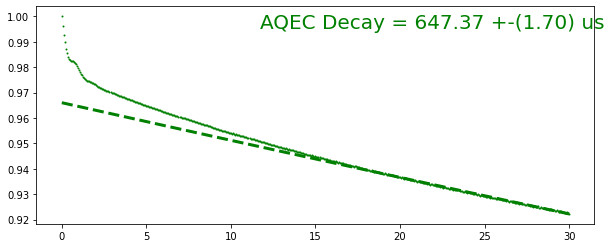

In [64]:
p_ggff, trackxp1, nq1, nq2, ge1, eg1, ff1 = compute_expectation_vals(result1, [gg_ff, trackxp, n1a, n2a, ge, eg, ff])
from scipy.optimize import curve_fit
def single_decay(x, a, Tfast):
    return a*np.exp(-x/Tfast)
vfig1 = plt.figure(figsize=(10,4))
guess = np.array([1, 50])
last_point = abs(trackxp1[-200:-1])
pfit33, pcov3 = curve_fit(single_decay, tlist[-200:-1], last_point, guess)
print(pfit33, np.sqrt(np.diag(pcov3)))
plt.text(0.4, 0.9, "AQEC Decay = %.2f +-(%.2f) us"%(pfit33[1] , np.sqrt(np.diag(pcov3))[1]), transform=plt.axes().transAxes, fontsize=20, color='green')
fit33 = single_decay(tlist, *pfit33)
plt.plot(np.array(tlist),fit33, color='green', linewidth=3, linestyle='--', marker='o',markersize=0.,label=r'AQEC fit')
plt.plot(tlist,abs(trackxp1), color='green', linewidth=3, linestyle='', marker='o',markersize=1.,label=r'AQEC')
logic_T_1d.append(pfit33[1])
logic_T_1d_err.append(np.sqrt(np.diag(pcov3))[1])
save1_x = abs(trackxp1)
save1_y = tlist

## Rotating frame

calculating T1: 32.0
Calculating T_1p
10.2%. Run time:   1.88s. Est. time left: 00:00:00:16
20.2%. Run time:   3.74s. Est. time left: 00:00:00:14
30.1%. Run time:   5.59s. Est. time left: 00:00:00:12
40.1%. Run time:   7.45s. Est. time left: 00:00:00:11
50.1%. Run time:   9.30s. Est. time left: 00:00:00:09
60.1%. Run time:  11.16s. Est. time left: 00:00:00:07
70.1%. Run time:  13.01s. Est. time left: 00:00:00:05
80.0%. Run time:  14.86s. Est. time left: 00:00:00:03
90.0%. Run time:  16.71s. Est. time left: 00:00:00:01
Total run time:  18.56s
[ 0.1144815  55.64243224  0.8439926 ] [0.00035975 0.24414794 0.00037442]


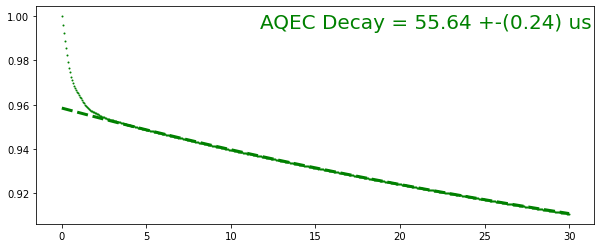

In [84]:
pi = np.pi
N_q = 3
N_r = 2
num = 2*pi
num1 = 1
delta1 = -160*num 
delta2 = -260*num 

Gamma_1r = 0.5*num
Gamma_2r = 0.5*num
n_th = 0.0
tlist = np.linspace(0,30,501)


Wr = 10*num
Wb = 10*num
Omega = 1*num*sqrt(2)
det1 = Wr/sqrt(3)
det2 = -Wr/sqrt(3)
QRD = 0.0*num

# T1(in us) = 1/gxx
logic_T_1d_err = []
logic_T_1d = []

T_list = np.linspace(32,40,1)

for TT in T_list:
    print('calculating T1:',TT)
    circuit_param = {'delta1':delta1, 'delta2':delta2, 'Gamma_1p':1/TT,'Gamma_2p':1/TT, "n_th":0, "QRD":QRD,
                     'Gamma_1r':Gamma_1r, 'Gamma_2r':Gamma_2r, 'Wr':Wr, 'Wb':Wb, 'Omega':Omega, 'det1':det1, 'det2': det2}

    # important settings to improve ODE solver
    options = Options()
    options.num_cpus=24
    options.atol = 1e-17
    options.rtol = 1e-12
    options.order = 100
    options.nsteps = 200000

    # starting at Lx
    dims = [N_q,N_q,N_r,N_r]
    gf_fg = tensor(ket("0",N_q)*bra("2",N_q), ket("2",N_q)*bra("0",N_q), qeye(N_r), qeye(N_r))
    gg_ff = tensor(ket("0",N_q)*bra("2",N_q), ket("0",N_q)*bra("2",N_q), qeye(N_r), qeye(N_r))
    psi0 = 1*(ket('0000',dim=dims) - ket('2200',dim=dims)) + 1*(1*ket('2000',dim=dims) - 1*ket('0200',dim=dims)) 
    # psi0 = ket('1200',dim=dims)
    psi0 = psi0.unit()
    cops2, result1 = stabilizationc(circuit_param, tlist, psi0, options)
    lgffg = (ket('2000',dim=dims) - ket('0200',dim=dims)).unit()
    lggff = (ket('0000',dim=dims) - ket('2200',dim=dims)).unit()
    llx = ((ket('0000',dim=dims) - ket('2200',dim=dims)) + (1*ket('2000',dim=dims) - 1*ket('0200',dim=dims))).unit()

    p_gffg, p_ggff, p_x = compute_fidelity_abs(result1, [lgffg, lggff, llx])
    Logical_Z, Logical_X = compute_fidelity_abs1(result1, [trackzz, trackxp])
    p1_ggff = compute_expectation_vals(result1, [gg_ff])
    from scipy.optimize import curve_fit
    def single_decay(x, a, Tfast, c0):
        return a*np.exp(-x/Tfast)+c0
    vfig1 = plt.figure(figsize=(10,4))
    guess = np.array([1, 50,0.0])
    pfit33, pcov3 = curve_fit(single_decay, tlist[60:-1], p_x[60:-1], guess)
    print(pfit33, np.sqrt(np.diag(pcov3)))
    plt.text(0.4, 0.9, "AQEC Decay = %.2f +-(%.2f) us"%(pfit33[1] , np.sqrt(np.diag(pcov3))[1]), transform=plt.axes().transAxes, fontsize=20, color='green')
    fit33 = single_decay(tlist, *pfit33)
    plt.plot(np.array(tlist),fit33, color='green', linewidth=3, linestyle='--', marker='o',markersize=0.,label=r'AQEC fit')
    plt.plot(tlist,p_x, color='green', linewidth=3, linestyle='', marker='o',markersize=1.,label=r'AQEC')
    logic_T_1d.append(pfit33[1])
    logic_T_1d_err.append(np.sqrt(np.diag(pcov3))[1])

Text(0, 0.5, 'Fidelity')

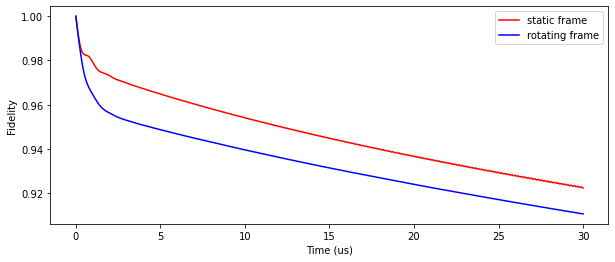

In [85]:
vfig1 = plt.figure(figsize=(10,4))
plt.plot(save1_y, save1_x, color='r', label='static frame')
plt.plot(tlist, p_x, color='b', label='rotating frame')
plt.legend()
plt.xlabel('Time (us)')
plt.ylabel('Fidelity')

[  0.95029811 702.52079221] [2.87477530e-05 5.52024995e-01]


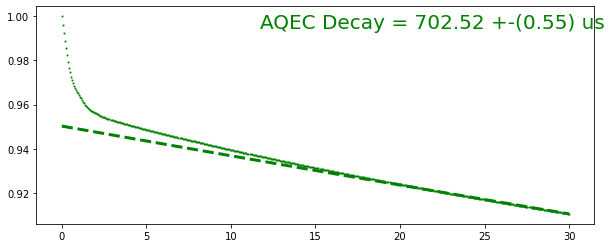

In [87]:
p_gffg, p_ggff, p_x = compute_fidelity_abs(result1, [lgffg, lggff, llx])
Logical_Z, Logical_X = compute_fidelity_abs1(result1, [trackzz, trackxp])
p1_ggff = compute_expectation_vals(result1, [gg_ff])
from scipy.optimize import curve_fit
def single_decay(x, a, Tfast):
    return a*np.exp(-x/Tfast)
vfig1 = plt.figure(figsize=(10,4))
guess = np.array([1, 50])
pfit33, pcov3 = curve_fit(single_decay, tlist[-100:-1], p_x[-100:-1], guess)
print(pfit33, np.sqrt(np.diag(pcov3)))
plt.text(0.4, 0.9, "AQEC Decay = %.2f +-(%.2f) us"%(pfit33[1] , np.sqrt(np.diag(pcov3))[1]), transform=plt.axes().transAxes, fontsize=20, color='green')
fit33 = single_decay(tlist, *pfit33)
plt.plot(np.array(tlist),fit33, color='green', linewidth=3, linestyle='--', marker='o',markersize=0.,label=r'AQEC fit')
plt.plot(tlist,p_x, color='green', linewidth=3, linestyle='', marker='o',markersize=1.,label=r'AQEC')
logic_T_1d.append(pfit33[1])
logic_T_1d_err.append(np.sqrt(np.diag(pcov3))[1])

# lifetime sweep rotating frame

## L0 W=1.5MHz, det=0.85, Omega=0.4, kappa=0.5

calculating T1: 10
Calculating T_1p
10.0%. Run time:  10.04s. Est. time left: 00:00:01:29
20.0%. Run time:  20.04s. Est. time left: 00:00:01:19
30.0%. Run time:  30.04s. Est. time left: 00:00:01:09
40.0%. Run time:  40.03s. Est. time left: 00:00:00:59
50.0%. Run time:  50.01s. Est. time left: 00:00:00:49
60.0%. Run time:  60.04s. Est. time left: 00:00:00:39
70.0%. Run time:  70.02s. Est. time left: 00:00:00:29
80.0%. Run time:  79.99s. Est. time left: 00:00:00:19
90.0%. Run time:  89.97s. Est. time left: 00:00:00:09
Total run time:  99.90s


/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/numpy/lib/function_base.py:486: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[-0.15941142 15.27573808 -0.20683934] [1.33231097e-04 9.57843965e-03 3.35213099e-06]
calculating T1: 20
Calculating T_1p
10.0%. Run time:   8.77s. Est. time left: 00:00:01:18
20.0%. Run time:  17.46s. Est. time left: 00:00:01:09
30.0%. Run time:  26.16s. Est. time left: 00:00:01:00
40.0%. Run time:  34.85s. Est. time left: 00:00:00:52
50.0%. Run time:  43.54s. Est. time left: 00:00:00:43
60.0%. Run time:  52.22s. Est. time left: 00:00:00:34
70.0%. Run time:  60.94s. Est. time left: 00:00:00:26
80.0%. Run time:  69.63s. Est. time left: 00:00:00:17
90.0%. Run time:  78.32s. Est. time left: 00:00:00:08
Total run time:  86.96s


/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/numpy/lib/function_base.py:486: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[-0.15340785 41.83369025 -0.25043301] [2.33830255e-04 7.90673870e-02 2.85962129e-05]
calculating T1: 30
Calculating T_1p
10.0%. Run time:  10.04s. Est. time left: 00:00:01:29
20.0%. Run time:  19.97s. Est. time left: 00:00:01:19
30.0%. Run time:  29.97s. Est. time left: 00:00:01:09
40.0%. Run time:  39.91s. Est. time left: 00:00:00:59
50.0%. Run time:  49.85s. Est. time left: 00:00:00:49
60.0%. Run time:  59.79s. Est. time left: 00:00:00:39
70.0%. Run time:  69.73s. Est. time left: 00:00:00:29
80.0%. Run time:  79.66s. Est. time left: 00:00:00:19
90.0%. Run time:  89.59s. Est. time left: 00:00:00:09
Total run time:  99.47s


/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/numpy/lib/function_base.py:486: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[-0.1530146  71.69752319 -0.26890953] [2.76160136e-04 2.21980597e-01 7.65235527e-05]
calculating T1: 40
Calculating T_1p
10.0%. Run time:   9.71s. Est. time left: 00:00:01:26
20.0%. Run time:  19.34s. Est. time left: 00:00:01:17
30.0%. Run time:  28.98s. Est. time left: 00:00:01:07
40.0%. Run time:  38.61s. Est. time left: 00:00:00:57
50.0%. Run time:  48.24s. Est. time left: 00:00:00:48
60.0%. Run time:  57.88s. Est. time left: 00:00:00:38
70.0%. Run time:  67.51s. Est. time left: 00:00:00:28
80.0%. Run time:  77.16s. Est. time left: 00:00:00:19
90.0%. Run time:  86.80s. Est. time left: 00:00:00:09
Total run time:  96.39s
[-0.1526062  98.02818478 -0.28160573] [2.86677512e-04 4.21190503e-01 1.42317128e-04]


/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/numpy/lib/function_base.py:486: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


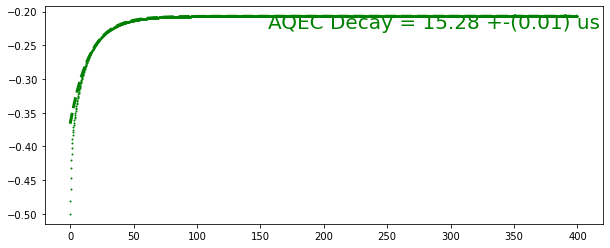

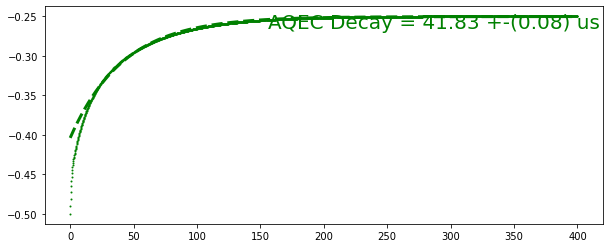

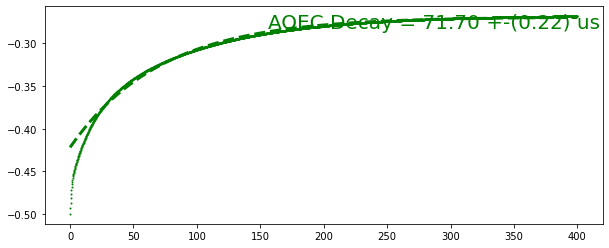

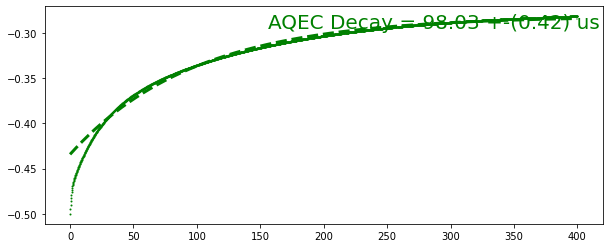

In [32]:
pi = np.pi
N_q = 3
N_r = 2
num = 2*pi
num1 = 1
delta1 = -116*num 
delta2 = -160*num 

Gamma_1r = 0.5*num
Gamma_2r = 0.5*num
n_th = 0.0
tlist = np.linspace(0,400,2001)


Wr = 1.5*num
Wb = 1.5*num
Omega = 0.4*num
det1 = 0.85*num
det2 = -0.85*num
QRD = 0.0*num

# T1(in us) = 1/gxx
logic_T_1d_err = []
logic_T_1d = []

T_list = np.array([10,20,30,40])

for TT in T_list:
    print('calculating T1:',TT)
    circuit_param = {'delta1':delta1, 'delta2':delta2, 'Gamma_1p':1/TT,'Gamma_2p':1/TT, "n_th":0, "QRD":QRD,
                     'Gamma_1r':Gamma_1r, 'Gamma_2r':Gamma_2r, 'Wr':Wr, 'Wb':Wb, 'Omega':Omega, 'det1':det1, 'det2': det2}

    # important settings to improve ODE solver
    options = Options()
    options.num_cpus=24
    options.atol = 1e-17
    options.rtol = 1e-12
    options.order = 100
    options.nsteps = 200000

    # starting at Lx
    dims = [N_q,N_q,N_r,N_r]
    gf_fg = tensor(ket("0",N_q)*bra("2",N_q), ket("2",N_q)*bra("0",N_q), qeye(N_r), qeye(N_r))
    psi0 = 0*(ket('0000',dim=dims) - ket('2200',dim=dims)) + 1*(1*ket('2000',dim=dims) - 1*ket('0200',dim=dims)) 
    # psi0 = ket('1200',dim=dims)
    psi0 = psi0.unit()
    cops2, result1 = stabilizationc(circuit_param, tlist, psi0, options)
    lgffg = (ket('2000',dim=dims) - ket('0200',dim=dims)).unit()
    lggff = (ket('0000',dim=dims) - ket('2200',dim=dims)).unit()
    llx = ((ket('0000',dim=dims) - ket('2200',dim=dims)) + (1*ket('2000',dim=dims) - 1*ket('0200',dim=dims))).unit()

    p_gffg, p_ggff, p_x = compute_fidelity_abs(result1, [lgffg, lggff, llx])
    Logical_Z, Logical_X = compute_expectation_vals(result1, [trackzz, trackxp])
    p1_gffg = compute_expectation_vals(result1, [gf_fg])
    from scipy.optimize import curve_fit
    def single_decay(x, a, Tfast, c0):
        return a*np.exp(-x/Tfast)+c0
    vfig1 = plt.figure(figsize=(10,4))
    guess = np.array([1, 50,0.0])
    pfit33, pcov3 = curve_fit(single_decay, tlist[60:-1], p1_gffg[0][60:-1], guess)
    print(pfit33, np.sqrt(np.diag(pcov3)))
    plt.text(0.4, 0.9, "AQEC Decay = %.2f +-(%.2f) us"%(pfit33[1] , np.sqrt(np.diag(pcov3))[1]), transform=plt.axes().transAxes, fontsize=20, color='green')
    fit33 = single_decay(tlist, *pfit33)
    plt.plot(np.array(tlist),fit33, color='green', linewidth=3, linestyle='--', marker='o',markersize=0.,label=r'AQEC fit')
    plt.plot(tlist,p1_gffg[0], color='green', linewidth=3, linestyle='', marker='o',markersize=1.,label=r'AQEC')
    logic_T_1d.append(pfit33[1])
    logic_T_1d_err.append(np.sqrt(np.diag(pcov3))[1])

In [33]:
logic_T_1d

[15.275738077791111, 41.83369024630505, 71.69752319387318, 98.02818477776798]

In [34]:
logic_T_1d_err

[0.009578439649721823,
 0.07906738699261212,
 0.22198059718554133,
 0.42119050266798697]

calculating T1: 30
Calculating T_1p
10.0%. Run time:  19.86s. Est. time left: 00:00:02:58
20.0%. Run time:  39.68s. Est. time left: 00:00:02:38
30.0%. Run time:  59.52s. Est. time left: 00:00:02:18
40.0%. Run time:  79.34s. Est. time left: 00:00:01:58
50.0%. Run time:  99.16s. Est. time left: 00:00:01:39
60.0%. Run time: 118.96s. Est. time left: 00:00:01:19
70.0%. Run time: 138.78s. Est. time left: 00:00:00:59
80.0%. Run time: 158.80s. Est. time left: 00:00:00:39
90.0%. Run time: 178.60s. Est. time left: 00:00:00:19
Total run time: 198.34s


/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/numpy/lib/function_base.py:486: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[-0.15186677 75.17492149 -0.26735649] [2.06166810e-04 1.40404662e-01 2.93914850e-05]
calculating T1: 40
Calculating T_1p
10.0%. Run time:  19.28s. Est. time left: 00:00:02:53
20.0%. Run time:  38.49s. Est. time left: 00:00:02:33
30.0%. Run time:  57.68s. Est. time left: 00:00:02:14
40.0%. Run time:  76.88s. Est. time left: 00:00:01:55
50.0%. Run time:  96.11s. Est. time left: 00:00:01:36
60.0%. Run time: 115.33s. Est. time left: 00:00:01:16
70.0%. Run time: 134.50s. Est. time left: 00:00:00:57
80.0%. Run time: 153.71s. Est. time left: 00:00:00:38
90.0%. Run time: 172.89s. Est. time left: 00:00:00:19
Total run time: 192.08s
[ -0.15171742 110.43745918  -0.27694123] [2.27595479e-04 2.65966762e-01 5.11631197e-05]


/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/numpy/lib/function_base.py:486: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


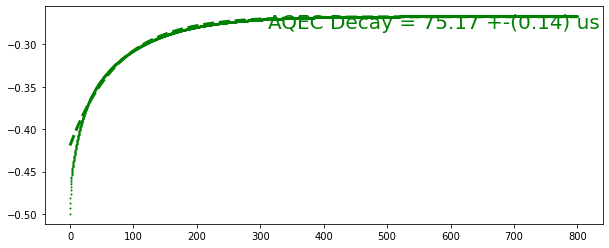

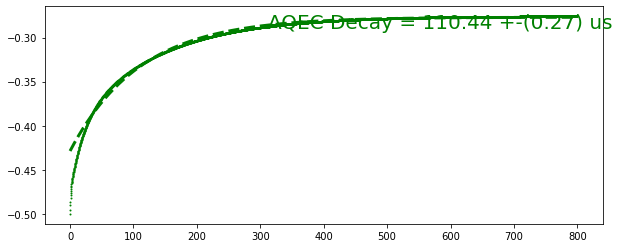

In [35]:
pi = np.pi
N_q = 3
N_r = 2
num = 2*pi
num1 = 1
delta1 = -116*num 
delta2 = -160*num 

Gamma_1r = 0.5*num
Gamma_2r = 0.5*num
n_th = 0.0
tlist = np.linspace(0,800,4001)


Wr = 1.5*num
Wb = 1.5*num
Omega = 0.4*num
det1 = 0.85*num
det2 = -0.85*num
QRD = 0.0*num

# T1(in us) = 1/gxx
logic_T_1d_err = []
logic_T_1d = []

T_list = np.array([30,40])

for TT in T_list:
    print('calculating T1:',TT)
    circuit_param = {'delta1':delta1, 'delta2':delta2, 'Gamma_1p':1/TT,'Gamma_2p':1/TT, "n_th":0, "QRD":QRD,
                     'Gamma_1r':Gamma_1r, 'Gamma_2r':Gamma_2r, 'Wr':Wr, 'Wb':Wb, 'Omega':Omega, 'det1':det1, 'det2': det2}

    # important settings to improve ODE solver
    options = Options()
    options.num_cpus=24
    options.atol = 1e-17
    options.rtol = 1e-12
    options.order = 100
    options.nsteps = 200000

    # starting at Lx
    dims = [N_q,N_q,N_r,N_r]
    gf_fg = tensor(ket("0",N_q)*bra("2",N_q), ket("2",N_q)*bra("0",N_q), qeye(N_r), qeye(N_r))
    psi0 = 0*(ket('0000',dim=dims) - ket('2200',dim=dims)) + 1*(1*ket('2000',dim=dims) - 1*ket('0200',dim=dims)) 
    # psi0 = ket('1200',dim=dims)
    psi0 = psi0.unit()
    cops2, result1 = stabilizationc(circuit_param, tlist, psi0, options)
    lgffg = (ket('2000',dim=dims) - ket('0200',dim=dims)).unit()
    lggff = (ket('0000',dim=dims) - ket('2200',dim=dims)).unit()
    llx = ((ket('0000',dim=dims) - ket('2200',dim=dims)) + (1*ket('2000',dim=dims) - 1*ket('0200',dim=dims))).unit()

    p_gffg, p_ggff, p_x = compute_fidelity_abs(result1, [lgffg, lggff, llx])
    Logical_Z, Logical_X = compute_expectation_vals(result1, [trackzz, trackxp])
    p1_gffg = compute_expectation_vals(result1, [gf_fg])
    from scipy.optimize import curve_fit
    def single_decay(x, a, Tfast, c0):
        return a*np.exp(-x/Tfast)+c0
    vfig1 = plt.figure(figsize=(10,4))
    guess = np.array([1, 50,0.0])
    pfit33, pcov3 = curve_fit(single_decay, tlist[60:-1], p1_gffg[0][60:-1], guess)
    print(pfit33, np.sqrt(np.diag(pcov3)))
    plt.text(0.4, 0.9, "AQEC Decay = %.2f +-(%.2f) us"%(pfit33[1] , np.sqrt(np.diag(pcov3))[1]), transform=plt.axes().transAxes, fontsize=20, color='green')
    fit33 = single_decay(tlist, *pfit33)
    plt.plot(np.array(tlist),fit33, color='green', linewidth=3, linestyle='--', marker='o',markersize=0.,label=r'AQEC fit')
    plt.plot(tlist,p1_gffg[0], color='green', linewidth=3, linestyle='', marker='o',markersize=1.,label=r'AQEC')
    logic_T_1d.append(pfit33[1])
    logic_T_1d_err.append(np.sqrt(np.diag(pcov3))[1])

In [36]:
logic_T_1d

[75.17492149487477, 110.4374591838506]

In [37]:
logic_T_1d_err

[0.1404046620511522, 0.26596676212012305]

## L1 W=1.5MHz, det=0.85, Omega=0.4, kappa=0.5

calculating T1: 10
Calculating T_1p
10.0%. Run time:  12.86s. Est. time left: 00:00:01:55
20.0%. Run time:  25.53s. Est. time left: 00:00:01:41
30.0%. Run time:  38.52s. Est. time left: 00:00:01:29
40.0%. Run time:  51.22s. Est. time left: 00:00:01:16
50.0%. Run time:  63.92s. Est. time left: 00:00:01:03
60.0%. Run time:  76.63s. Est. time left: 00:00:00:51
70.0%. Run time:  89.33s. Est. time left: 00:00:00:38
80.0%. Run time: 102.03s. Est. time left: 00:00:00:25
90.0%. Run time: 114.74s. Est. time left: 00:00:00:12
Total run time: 127.37s


/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/numpy/lib/function_base.py:486: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[-0.27788966 15.21259481 -0.06327784] [2.51522929e-04 1.03056634e-02 6.27876656e-06]
calculating T1: 20
Calculating T_1p
10.0%. Run time:  13.62s. Est. time left: 00:00:02:01
20.0%. Run time:  27.12s. Est. time left: 00:00:01:48
30.0%. Run time:  40.62s. Est. time left: 00:00:01:34
40.0%. Run time:  54.11s. Est. time left: 00:00:01:21
50.0%. Run time:  67.59s. Est. time left: 00:00:01:07
60.0%. Run time:  81.09s. Est. time left: 00:00:00:54
70.0%. Run time:  94.58s. Est. time left: 00:00:00:40
80.0%. Run time: 108.07s. Est. time left: 00:00:00:26
90.0%. Run time: 121.55s. Est. time left: 00:00:00:13
Total run time: 134.96s


/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/numpy/lib/function_base.py:486: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[-0.31653583 43.78972299 -0.07926796] [2.95575559e-04 5.18627589e-02 3.85601260e-05]
calculating T1: 30
Calculating T_1p
10.0%. Run time:  12.36s. Est. time left: 00:00:01:50
20.0%. Run time:  24.59s. Est. time left: 00:00:01:38
30.0%. Run time:  36.82s. Est. time left: 00:00:01:25
40.0%. Run time:  49.05s. Est. time left: 00:00:01:13
50.0%. Run time:  61.27s. Est. time left: 00:00:01:01
60.0%. Run time:  73.50s. Est. time left: 00:00:00:48
70.0%. Run time:  85.72s. Est. time left: 00:00:00:36
80.0%. Run time:  97.93s. Est. time left: 00:00:00:24
90.0%. Run time: 110.16s. Est. time left: 00:00:00:12
Total run time: 122.32s


/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/numpy/lib/function_base.py:486: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[-0.33073764 78.88068386 -0.08821047] [2.95779586e-04 1.30868070e-01 9.69156884e-05]
calculating T1: 40
Calculating T_1p
10.0%. Run time:  11.55s. Est. time left: 00:00:01:43
20.0%. Run time:  23.00s. Est. time left: 00:00:01:31
30.0%. Run time:  34.44s. Est. time left: 00:00:01:20
40.0%. Run time:  45.89s. Est. time left: 00:00:01:08
50.0%. Run time:  57.33s. Est. time left: 00:00:00:57
60.0%. Run time:  68.76s. Est. time left: 00:00:00:45
70.0%. Run time:  80.18s. Est. time left: 00:00:00:34
80.0%. Run time:  91.62s. Est. time left: 00:00:00:22
90.0%. Run time: 103.06s. Est. time left: 00:00:00:11
Total run time: 114.43s
[-3.36345161e-01  1.15159049e+02 -9.70254912e-02] [2.7805010e-04 2.5944251e-01 1.9161588e-04]


/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/numpy/lib/function_base.py:486: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


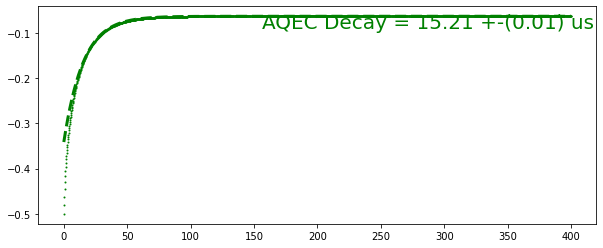

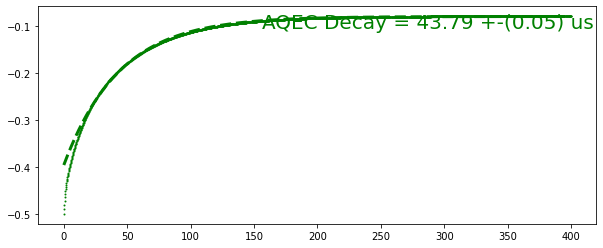

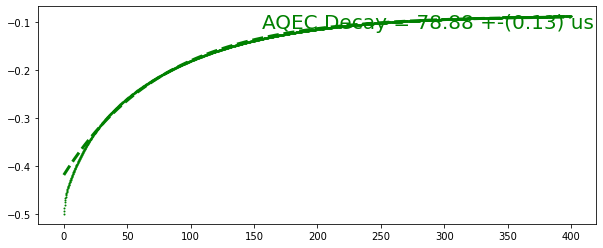

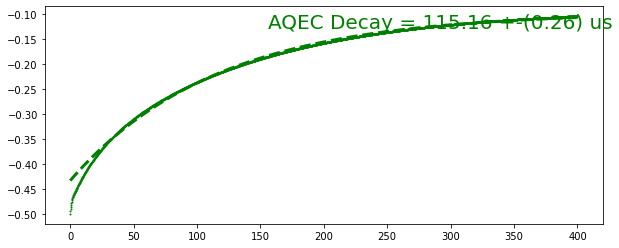

In [41]:
pi = np.pi
N_q = 3
N_r = 2
num = 2*pi
num1 = 1
delta1 = -116*num 
delta2 = -160*num 

Gamma_1r = 0.5*num
Gamma_2r = 0.5*num
n_th = 0.0
tlist = np.linspace(0,400,2001)


Wr = 1.5*num
Wb = 1.5*num
Omega = 0.4*num
det1 = 0.85*num
det2 = -0.85*num
QRD = 0.0*num

# T1(in us) = 1/gxx
logic_T_1d_err = []
logic_T_1d = []

T_list = np.array([10,20,30,40])

for TT in T_list:
    print('calculating T1:',TT)
    circuit_param = {'delta1':delta1, 'delta2':delta2, 'Gamma_1p':1/TT,'Gamma_2p':1/TT, "n_th":0, "QRD":QRD,
                     'Gamma_1r':Gamma_1r, 'Gamma_2r':Gamma_2r, 'Wr':Wr, 'Wb':Wb, 'Omega':Omega, 'det1':det1, 'det2': det2}

    # important settings to improve ODE solver
    options = Options()
    options.num_cpus=24
    options.atol = 1e-17
    options.rtol = 1e-12
    options.order = 100
    options.nsteps = 200000

    # starting at Lx
    dims = [N_q,N_q,N_r,N_r]
    gf_fg = tensor(ket("0",N_q)*bra("2",N_q), ket("2",N_q)*bra("0",N_q), qeye(N_r), qeye(N_r))
    gg_ff = tensor(ket("0",N_q)*bra("2",N_q), ket("0",N_q)*bra("2",N_q), qeye(N_r), qeye(N_r))
    psi0 = 1*(ket('0000',dim=dims) - ket('2200',dim=dims)) + 0*(1*ket('2000',dim=dims) - 1*ket('0200',dim=dims)) 
    # psi0 = ket('1200',dim=dims)
    psi0 = psi0.unit()
    cops2, result1 = stabilizationc(circuit_param, tlist, psi0, options)
    lgffg = (ket('2000',dim=dims) - ket('0200',dim=dims)).unit()
    lggff = (ket('0000',dim=dims) - ket('2200',dim=dims)).unit()
    llx = ((ket('0000',dim=dims) - ket('2200',dim=dims)) + (1*ket('2000',dim=dims) - 1*ket('0200',dim=dims))).unit()

    p_gffg, p_ggff, p_x = compute_fidelity_abs(result1, [lgffg, lggff, llx])
    Logical_Z, Logical_X = compute_expectation_vals(result1, [trackzz, trackxp])
    p1_gffg, p1_ggff = compute_expectation_vals(result1, [gf_fg, gg_ff])
    from scipy.optimize import curve_fit
    def single_decay(x, a, Tfast, c0):
        return a*np.exp(-x/Tfast)+c0
    vfig1 = plt.figure(figsize=(10,4))
    guess = np.array([1, 50,0.0])
    pfit33, pcov3 = curve_fit(single_decay, tlist[60:-1], p1_ggff[60:-1], guess)
    print(pfit33, np.sqrt(np.diag(pcov3)))
    plt.text(0.4, 0.9, "AQEC Decay = %.2f +-(%.2f) us"%(pfit33[1] , np.sqrt(np.diag(pcov3))[1]), transform=plt.axes().transAxes, fontsize=20, color='green')
    fit33 = single_decay(tlist, *pfit33)
    plt.plot(np.array(tlist),fit33, color='green', linewidth=3, linestyle='--', marker='o',markersize=0.,label=r'AQEC fit')
    plt.plot(tlist,p1_ggff, color='green', linewidth=3, linestyle='', marker='o',markersize=1.,label=r'AQEC')
    logic_T_1d.append(pfit33[1])
    logic_T_1d_err.append(np.sqrt(np.diag(pcov3))[1])

In [42]:
logic_T_1d

[15.212594809819775, 43.78972299485124, 78.88068385888243, 115.15904926492864]

In [43]:
logic_T_1d_err

[0.010305663448148513,
 0.0518627588819063,
 0.13086806952791677,
 0.2594425101027451]

## Lx W=1.5MHz, det=0.85, Omega=0.4, kappa=0.5

calculating T1: 10
Calculating T_1p
10.0%. Run time:  13.49s. Est. time left: 00:00:02:00
20.0%. Run time:  26.88s. Est. time left: 00:00:01:47
30.0%. Run time:  40.24s. Est. time left: 00:00:01:33
40.0%. Run time:  53.61s. Est. time left: 00:00:01:20
50.0%. Run time:  66.98s. Est. time left: 00:00:01:06
60.0%. Run time:  80.34s. Est. time left: 00:00:00:53
70.0%. Run time:  93.76s. Est. time left: 00:00:00:40
80.0%. Run time: 107.11s. Est. time left: 00:00:00:26
90.0%. Run time: 120.46s. Est. time left: 00:00:00:13
Total run time: 133.74s
[ 0.41949577 18.02579335  0.31203415] [3.91053138e-04 1.38256567e-02 1.33033973e-05]
calculating T1: 20
Calculating T_1p
10.0%. Run time:  12.09s. Est. time left: 00:00:01:48
20.0%. Run time:  24.08s. Est. time left: 00:00:01:36
30.0%. Run time:  36.07s. Est. time left: 00:00:01:24
40.0%. Run time:  48.07s. Est. time left: 00:00:01:12
50.0%. Run time:  60.06s. Est. time left: 00:00:00:59
60.0%. Run time:  72.04s. Est. time left: 00:00:00:47
70.0%. Ru

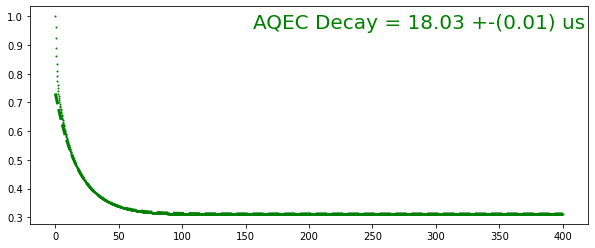

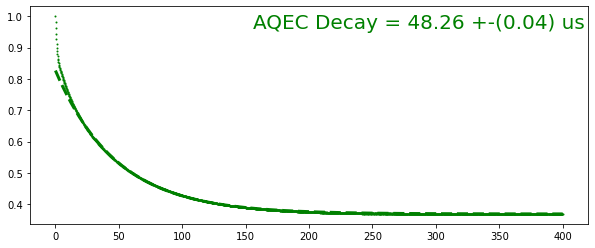

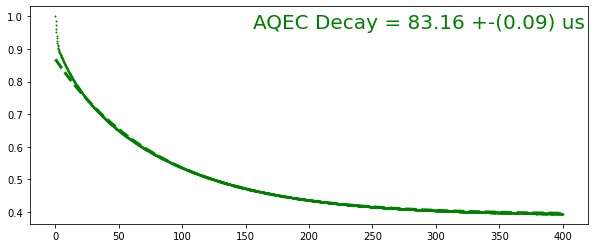

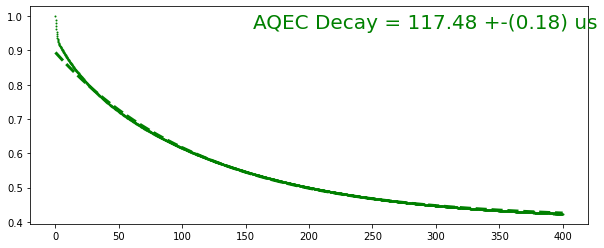

In [44]:
pi = np.pi
N_q = 3
N_r = 2
num = 2*pi
num1 = 1
delta1 = -116*num 
delta2 = -160*num 

Gamma_1r = 0.5*num
Gamma_2r = 0.5*num
n_th = 0.0
tlist = np.linspace(0,400,2001)


Wr = 1.5*num
Wb = 1.5*num
Omega = 0.4*num
det1 = 0.85*num
det2 = -0.85*num
QRD = 0.0*num

# T1(in us) = 1/gxx
logic_T_1d_err = []
logic_T_1d = []

T_list = np.array([10,20,30,40])

for TT in T_list:
    print('calculating T1:',TT)
    circuit_param = {'delta1':delta1, 'delta2':delta2, 'Gamma_1p':1/TT,'Gamma_2p':1/TT, "n_th":0, "QRD":QRD,
                     'Gamma_1r':Gamma_1r, 'Gamma_2r':Gamma_2r, 'Wr':Wr, 'Wb':Wb, 'Omega':Omega, 'det1':det1, 'det2': det2}

    # important settings to improve ODE solver
    options = Options()
    options.num_cpus=24
    options.atol = 1e-17
    options.rtol = 1e-12
    options.order = 100
    options.nsteps = 200000

    # starting at Lx
    dims = [N_q,N_q,N_r,N_r]
    gf_fg = tensor(ket("0",N_q)*bra("2",N_q), ket("2",N_q)*bra("0",N_q), qeye(N_r), qeye(N_r))
    gg_ff = tensor(ket("0",N_q)*bra("2",N_q), ket("0",N_q)*bra("2",N_q), qeye(N_r), qeye(N_r))
    psi0 = 1*(ket('0000',dim=dims) - ket('2200',dim=dims)) + 1*(1*ket('2000',dim=dims) - 1*ket('0200',dim=dims)) 
    # psi0 = ket('1200',dim=dims)
    psi0 = psi0.unit()
    cops2, result1 = stabilizationc(circuit_param, tlist, psi0, options)
    lgffg = (ket('2000',dim=dims) - ket('0200',dim=dims)).unit()
    lggff = (ket('0000',dim=dims) - ket('2200',dim=dims)).unit()
    llx = ((ket('0000',dim=dims) - ket('2200',dim=dims)) + (1*ket('2000',dim=dims) - 1*ket('0200',dim=dims))).unit()

    p_gffg, p_ggff, p_x = compute_fidelity_abs(result1, [lgffg, lggff, llx])
    Logical_Z, Logical_X = compute_expectation_vals(result1, [trackzz, trackxp])
    p1_gffg, p1_ggff = compute_expectation_vals(result1, [gf_fg, gg_ff])
    from scipy.optimize import curve_fit
    def single_decay(x, a, Tfast, c0):
        return a*np.exp(-x/Tfast)+c0
    vfig1 = plt.figure(figsize=(10,4))
    guess = np.array([1, 50,0.0])
    pfit33, pcov3 = curve_fit(single_decay, tlist[60:-1], p_x[60:-1], guess)
    print(pfit33, np.sqrt(np.diag(pcov3)))
    plt.text(0.4, 0.9, "AQEC Decay = %.2f +-(%.2f) us"%(pfit33[1] , np.sqrt(np.diag(pcov3))[1]), transform=plt.axes().transAxes, fontsize=20, color='green')
    fit33 = single_decay(tlist, *pfit33)
    plt.plot(np.array(tlist),fit33, color='green', linewidth=3, linestyle='--', marker='o',markersize=0.,label=r'AQEC fit')
    plt.plot(tlist,p_x, color='green', linewidth=3, linestyle='', marker='o',markersize=1.,label=r'AQEC')
    logic_T_1d.append(pfit33[1])
    logic_T_1d_err.append(np.sqrt(np.diag(pcov3))[1])

In [45]:
logic_T_1d

[18.025793347287944, 48.26438002180511, 83.16278783242399, 117.47621221592199]

In [46]:
logic_T_1d_err

[0.013825656715528238,
 0.03670868004174458,
 0.09377235743920546,
 0.18077901879366157]

calculating T1: 30
Calculating T_1p
10.0%. Run time:  21.78s. Est. time left: 00:00:03:15
20.0%. Run time:  43.50s. Est. time left: 00:00:02:53
30.0%. Run time:  65.20s. Est. time left: 00:00:02:32
40.0%. Run time:  86.92s. Est. time left: 00:00:02:10
50.0%. Run time: 108.60s. Est. time left: 00:00:01:48
60.0%. Run time: 130.30s. Est. time left: 00:00:01:26
70.0%. Run time: 151.97s. Est. time left: 00:00:01:05
80.0%. Run time: 173.64s. Est. time left: 00:00:00:43
90.0%. Run time: 195.32s. Est. time left: 00:00:00:21
Total run time: 216.99s
[ 0.47610258 82.78717448  0.39302943] [2.03795118e-04 5.04381792e-02 3.23932575e-05]
calculating T1: 40
Calculating T_1p
10.0%. Run time:  20.64s. Est. time left: 00:00:03:05
20.0%. Run time:  41.20s. Est. time left: 00:00:02:44
30.0%. Run time:  61.75s. Est. time left: 00:00:02:23
40.0%. Run time:  82.30s. Est. time left: 00:00:02:03
50.0%. Run time: 102.90s. Est. time left: 00:00:01:42
60.0%. Run time: 123.44s. Est. time left: 00:00:01:22
70.0%. Ru

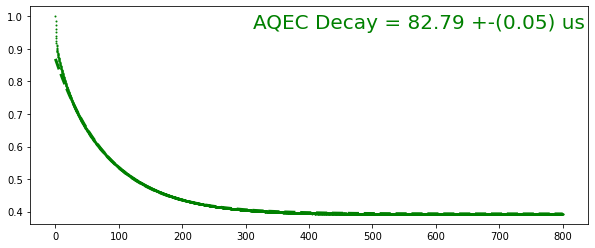

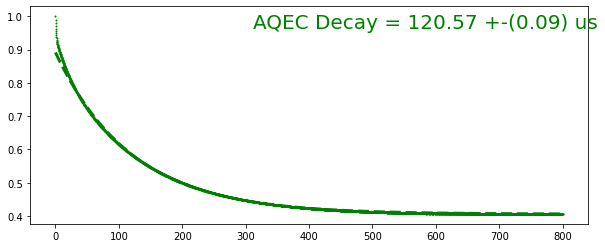

In [47]:
pi = np.pi
N_q = 3
N_r = 2
num = 2*pi
num1 = 1
delta1 = -116*num 
delta2 = -160*num 

Gamma_1r = 0.5*num
Gamma_2r = 0.5*num
n_th = 0.0
tlist = np.linspace(0,800,4001)


Wr = 1.5*num
Wb = 1.5*num
Omega = 0.4*num
det1 = 0.85*num
det2 = -0.85*num
QRD = 0.0*num

# T1(in us) = 1/gxx
logic_T_1d_err = []
logic_T_1d = []

T_list = np.array([30,40])

for TT in T_list:
    print('calculating T1:',TT)
    circuit_param = {'delta1':delta1, 'delta2':delta2, 'Gamma_1p':1/TT,'Gamma_2p':1/TT, "n_th":0, "QRD":QRD,
                     'Gamma_1r':Gamma_1r, 'Gamma_2r':Gamma_2r, 'Wr':Wr, 'Wb':Wb, 'Omega':Omega, 'det1':det1, 'det2': det2}

    # important settings to improve ODE solver
    options = Options()
    options.num_cpus=24
    options.atol = 1e-17
    options.rtol = 1e-12
    options.order = 100
    options.nsteps = 200000

    # starting at Lx
    dims = [N_q,N_q,N_r,N_r]
    gf_fg = tensor(ket("0",N_q)*bra("2",N_q), ket("2",N_q)*bra("0",N_q), qeye(N_r), qeye(N_r))
    gg_ff = tensor(ket("0",N_q)*bra("2",N_q), ket("0",N_q)*bra("2",N_q), qeye(N_r), qeye(N_r))
    psi0 = 1*(ket('0000',dim=dims) - ket('2200',dim=dims)) + 1*(1*ket('2000',dim=dims) - 1*ket('0200',dim=dims)) 
    # psi0 = ket('1200',dim=dims)
    psi0 = psi0.unit()
    cops2, result1 = stabilizationc(circuit_param, tlist, psi0, options)
    lgffg = (ket('2000',dim=dims) - ket('0200',dim=dims)).unit()
    lggff = (ket('0000',dim=dims) - ket('2200',dim=dims)).unit()
    llx = ((ket('0000',dim=dims) - ket('2200',dim=dims)) + (1*ket('2000',dim=dims) - 1*ket('0200',dim=dims))).unit()

    p_gffg, p_ggff, p_x = compute_fidelity_abs(result1, [lgffg, lggff, llx])
    Logical_Z, Logical_X = compute_expectation_vals(result1, [trackzz, trackxp])
    p1_gffg, p1_ggff = compute_expectation_vals(result1, [gf_fg, gg_ff])
    from scipy.optimize import curve_fit
    def single_decay(x, a, Tfast, c0):
        return a*np.exp(-x/Tfast)+c0
    vfig1 = plt.figure(figsize=(10,4))
    guess = np.array([1, 50,0.0])
    pfit33, pcov3 = curve_fit(single_decay, tlist[60:-1], p_x[60:-1], guess)
    print(pfit33, np.sqrt(np.diag(pcov3)))
    plt.text(0.4, 0.9, "AQEC Decay = %.2f +-(%.2f) us"%(pfit33[1] , np.sqrt(np.diag(pcov3))[1]), transform=plt.axes().transAxes, fontsize=20, color='green')
    fit33 = single_decay(tlist, *pfit33)
    plt.plot(np.array(tlist),fit33, color='green', linewidth=3, linestyle='--', marker='o',markersize=0.,label=r'AQEC fit')
    plt.plot(tlist,p_x, color='green', linewidth=3, linestyle='', marker='o',markersize=1.,label=r'AQEC')
    logic_T_1d.append(pfit33[1])
    logic_T_1d_err.append(np.sqrt(np.diag(pcov3))[1])

In [48]:
logic_T_1d

[82.78717448223021, 120.56779829308341]

In [49]:
logic_T_1d_err

[0.0504381791646313, 0.08643722574007644]

## L0 W=5MHz, det=2.5, Omega=1.0, kappa=0.5

calculating T1: 10
Calculating T_1p
10.0%. Run time:  42.69s. Est. time left: 00:00:06:23
20.0%. Run time:  85.35s. Est. time left: 00:00:05:40
30.0%. Run time: 127.96s. Est. time left: 00:00:04:58
40.0%. Run time: 170.53s. Est. time left: 00:00:04:15
50.0%. Run time: 213.11s. Est. time left: 00:00:03:33
60.0%. Run time: 255.81s. Est. time left: 00:00:02:50
70.0%. Run time: 298.87s. Est. time left: 00:00:02:08
80.0%. Run time: 341.95s. Est. time left: 00:00:01:25
90.0%. Run time: 385.08s. Est. time left: 00:00:00:42
Total run time: 428.08s


/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/numpy/lib/function_base.py:486: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[-0.13572888 34.71653585 -0.29819413] [4.11280428e-06 8.31409832e-04 8.78889178e-08]
calculating T1: 20
Calculating T_1p
10.0%. Run time:  38.86s. Est. time left: 00:00:05:48
20.0%. Run time:  77.59s. Est. time left: 00:00:05:09
30.0%. Run time: 116.29s. Est. time left: 00:00:04:31
40.0%. Run time: 154.98s. Est. time left: 00:00:03:52
50.0%. Run time: 193.66s. Est. time left: 00:00:03:13
60.0%. Run time: 232.35s. Est. time left: 00:00:02:34
70.0%. Run time: 271.22s. Est. time left: 00:00:01:56
80.0%. Run time: 309.91s. Est. time left: 00:00:01:17
90.0%. Run time: 348.74s. Est. time left: 00:00:00:38
Total run time: 387.34s


/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/numpy/lib/function_base.py:486: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[ -0.13629361 109.15579461  -0.31857391] [1.70550890e-05 1.69405356e-02 1.70506309e-06]
calculating T1: 30
Calculating T_1p
10.0%. Run time:  36.66s. Est. time left: 00:00:05:29
20.0%. Run time:  73.28s. Est. time left: 00:00:04:52
30.0%. Run time: 109.82s. Est. time left: 00:00:04:16
40.0%. Run time: 146.33s. Est. time left: 00:00:03:39
50.0%. Run time: 182.88s. Est. time left: 00:00:03:02
60.0%. Run time: 219.44s. Est. time left: 00:00:02:26
70.0%. Run time: 255.97s. Est. time left: 00:00:01:49
80.0%. Run time: 292.53s. Est. time left: 00:00:01:13
90.0%. Run time: 329.10s. Est. time left: 00:00:00:36
Total run time: 365.56s


/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/numpy/lib/function_base.py:486: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[-1.38686624e-01  2.06838613e+02 -3.24284415e-01] [2.81820422e-05 6.54318404e-02 5.83094182e-06]
calculating T1: 40
Calculating T_1p
10.0%. Run time:  35.42s. Est. time left: 00:00:05:17
20.0%. Run time:  70.70s. Est. time left: 00:00:04:42
30.0%. Run time: 106.01s. Est. time left: 00:00:04:07
40.0%. Run time: 141.30s. Est. time left: 00:00:03:31
50.0%. Run time: 176.63s. Est. time left: 00:00:02:56
60.0%. Run time: 211.92s. Est. time left: 00:00:02:21
70.0%. Run time: 247.24s. Est. time left: 00:00:01:45
80.0%. Run time: 282.56s. Est. time left: 00:00:01:10
90.0%. Run time: 317.88s. Est. time left: 00:00:00:35
Total run time: 353.12s
[-1.40856824e-01  3.18594938e+02 -3.26522507e-01] [3.58597058e-05 1.63380911e-01 1.37064663e-05]


/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/numpy/lib/function_base.py:486: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


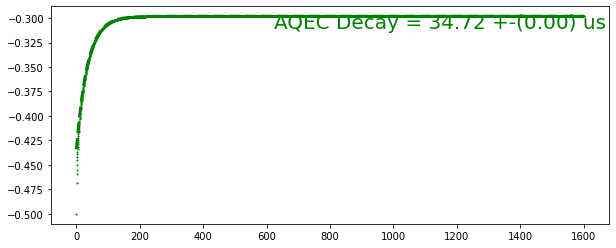

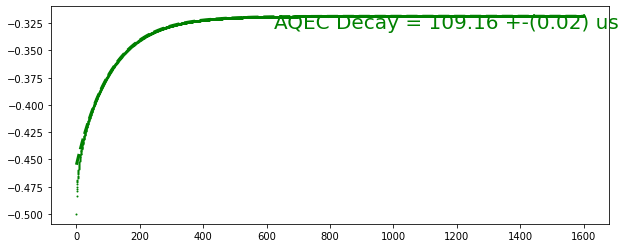

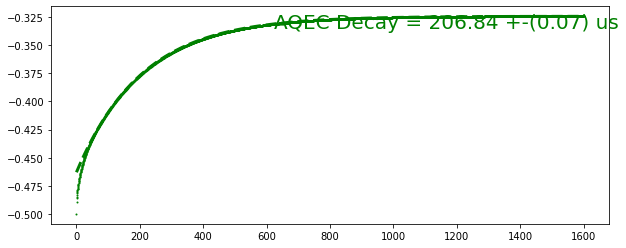

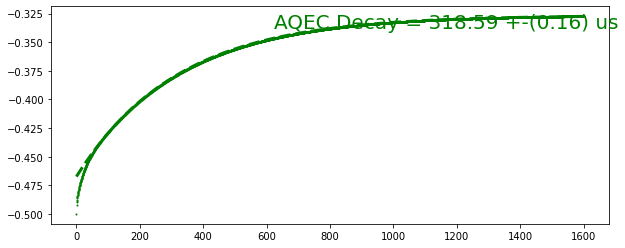

In [53]:
pi = np.pi
N_q = 3
N_r = 2
num = 2*pi
num1 = 1
delta1 = -116*num 
delta2 = -160*num 

Gamma_1r = 0.5*num
Gamma_2r = 0.5*num
n_th = 0.0
tlist = np.linspace(0,1600,4001)


Wr = 5*num
Wb = 5*num
Omega = 1.0*num
det1 = 2.5*num
det2 = -2.5*num
QRD = 0.0*num

# T1(in us) = 1/gxx
logic_T_1d_err = []
logic_T_1d = []

T_list = np.array([10,20,30,40])

for TT in T_list:
    print('calculating T1:',TT)
    circuit_param = {'delta1':delta1, 'delta2':delta2, 'Gamma_1p':1/TT,'Gamma_2p':1/TT, "n_th":0, "QRD":QRD,
                     'Gamma_1r':Gamma_1r, 'Gamma_2r':Gamma_2r, 'Wr':Wr, 'Wb':Wb, 'Omega':Omega, 'det1':det1, 'det2': det2}

    # important settings to improve ODE solver
    options = Options()
    options.num_cpus=24
    options.atol = 1e-17
    options.rtol = 1e-12
    options.order = 100
    options.nsteps = 200000

    # starting at Lx
    dims = [N_q,N_q,N_r,N_r]
    gf_fg = tensor(ket("0",N_q)*bra("2",N_q), ket("2",N_q)*bra("0",N_q), qeye(N_r), qeye(N_r))
    psi0 = 0*(ket('0000',dim=dims) - ket('2200',dim=dims)) + 1*(1*ket('2000',dim=dims) - 1*ket('0200',dim=dims)) 
    # psi0 = ket('1200',dim=dims)
    psi0 = psi0.unit()
    cops2, result1 = stabilizationc(circuit_param, tlist, psi0, options)
    lgffg = (ket('2000',dim=dims) - ket('0200',dim=dims)).unit()
    lggff = (ket('0000',dim=dims) - ket('2200',dim=dims)).unit()
    llx = ((ket('0000',dim=dims) - ket('2200',dim=dims)) + (1*ket('2000',dim=dims) - 1*ket('0200',dim=dims))).unit()

    p_gffg, p_ggff, p_x = compute_fidelity_abs(result1, [lgffg, lggff, llx])
    Logical_Z, Logical_X = compute_expectation_vals(result1, [trackzz, trackxp])
    p1_gffg = compute_expectation_vals(result1, [gf_fg])
    from scipy.optimize import curve_fit
    def single_decay(x, a, Tfast, c0):
        return a*np.exp(-x/Tfast)+c0
    vfig1 = plt.figure(figsize=(10,4))
    guess = np.array([1, 50,0.0])
    pfit33, pcov3 = curve_fit(single_decay, tlist[60:-1], p1_gffg[0][60:-1], guess)
    print(pfit33, np.sqrt(np.diag(pcov3)))
    plt.text(0.4, 0.9, "AQEC Decay = %.2f +-(%.2f) us"%(pfit33[1] , np.sqrt(np.diag(pcov3))[1]), transform=plt.axes().transAxes, fontsize=20, color='green')
    fit33 = single_decay(tlist, *pfit33)
    plt.plot(np.array(tlist),fit33, color='green', linewidth=3, linestyle='--', marker='o',markersize=0.,label=r'AQEC fit')
    plt.plot(tlist,p1_gffg[0], color='green', linewidth=3, linestyle='', marker='o',markersize=1.,label=r'AQEC')
    logic_T_1d.append(pfit33[1])
    logic_T_1d_err.append(np.sqrt(np.diag(pcov3))[1])

In [54]:
logic_T_1d

[34.716535853372115, 109.15579461178228, 206.8386125372907, 318.59493831690617]

In [55]:
logic_T_1d_err

[0.0008314098317464193,
 0.016940535590617277,
 0.06543184036780958,
 0.1633809112988886]

## L1 W=5MHz, det=2.5, Omega=1.0, kappa=0.5

calculating T1: 10
Calculating T_1p
10.0%. Run time:  77.28s. Est. time left: 00:00:11:33
20.0%. Run time: 154.41s. Est. time left: 00:00:10:16
30.0%. Run time: 231.52s. Est. time left: 00:00:08:59
40.0%. Run time: 308.59s. Est. time left: 00:00:07:42
50.0%. Run time: 385.71s. Est. time left: 00:00:06:25
60.0%. Run time: 462.96s. Est. time left: 00:00:05:08
70.0%. Run time: 540.86s. Est. time left: 00:00:03:51
80.0%. Run time: 619.06s. Est. time left: 00:00:02:34
90.0%. Run time: 697.27s. Est. time left: 00:00:01:17
Total run time: 775.44s


/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/numpy/lib/function_base.py:486: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[-0.31869086 34.72682172 -0.09913964] [7.49976396e-06 6.45984777e-04 1.60348708e-07]
calculating T1: 20
Calculating T_1p
10.0%. Run time:  58.06s. Est. time left: 00:00:08:41
20.0%. Run time: 115.91s. Est. time left: 00:00:07:43
30.0%. Run time: 173.75s. Est. time left: 00:00:06:45
40.0%. Run time: 231.59s. Est. time left: 00:00:05:47
50.0%. Run time: 289.42s. Est. time left: 00:00:04:49
60.0%. Run time: 347.22s. Est. time left: 00:00:03:51
70.0%. Run time: 405.08s. Est. time left: 00:00:02:53
80.0%. Run time: 462.87s. Est. time left: 00:00:01:55
90.0%. Run time: 520.76s. Est. time left: 00:00:00:57
Total run time: 578.40s


/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/numpy/lib/function_base.py:486: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[ -0.33697466 109.48630428  -0.11172733] [2.26725834e-05 9.14495203e-03 2.27432027e-06]
calculating T1: 30
Calculating T_1p
10.0%. Run time:  51.86s. Est. time left: 00:00:07:45
20.0%. Run time: 103.47s. Est. time left: 00:00:06:53
30.0%. Run time: 155.09s. Est. time left: 00:00:06:01
40.0%. Run time: 206.73s. Est. time left: 00:00:05:09
50.0%. Run time: 258.35s. Est. time left: 00:00:04:18
60.0%. Run time: 309.96s. Est. time left: 00:00:03:26
70.0%. Run time: 361.58s. Est. time left: 00:00:02:34
80.0%. Run time: 413.23s. Est. time left: 00:00:01:43
90.0%. Run time: 464.89s. Est. time left: 00:00:00:51
Total run time: 516.31s


/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/numpy/lib/function_base.py:486: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[-3.42201256e-01  2.08157247e+02 -1.18143705e-01] [3.24269781e-05 3.07952438e-02 6.76246029e-06]
calculating T1: 40
Calculating T_1p
10.0%. Run time:  52.43s. Est. time left: 00:00:07:50
20.0%. Run time: 104.66s. Est. time left: 00:00:06:58
30.0%. Run time: 156.88s. Est. time left: 00:00:06:05
40.0%. Run time: 209.09s. Est. time left: 00:00:05:13
50.0%. Run time: 261.32s. Est. time left: 00:00:04:21
60.0%. Run time: 313.72s. Est. time left: 00:00:03:29
70.0%. Run time: 366.11s. Est. time left: 00:00:02:36
80.0%. Run time: 418.48s. Est. time left: 00:00:01:44
90.0%. Run time: 470.84s. Est. time left: 00:00:00:52
Total run time: 523.09s
[-3.44059684e-01  3.22006250e+02 -1.22487412e-01] [3.78654690e-05 7.19769033e-02 1.47279879e-05]


/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/numpy/lib/function_base.py:486: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


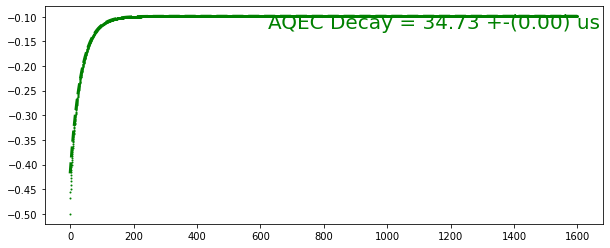

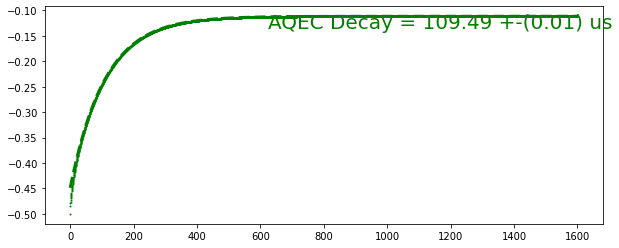

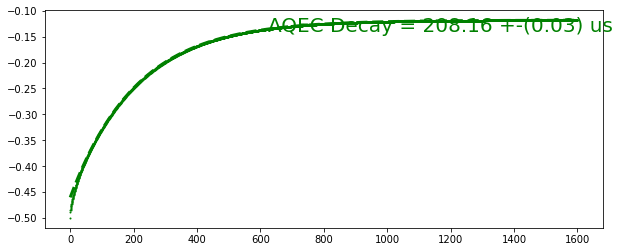

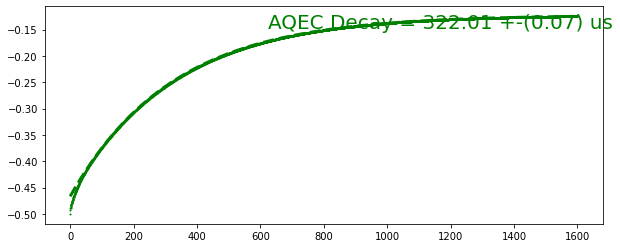

In [57]:
pi = np.pi
N_q = 3
N_r = 2
num = 2*pi
num1 = 1
delta1 = -116*num 
delta2 = -160*num 

Gamma_1r = 0.5*num
Gamma_2r = 0.5*num
n_th = 0.0
tlist = np.linspace(0,1600,4001)


Wr = 5*num
Wb = 5*num
Omega = 1.0*num
det1 = 2.5*num
det2 = -2.5*num
QRD = 0.0*num

# T1(in us) = 1/gxx
logic_T_1d_err = []
logic_T_1d = []

T_list = np.array([10,20,30,40])

for TT in T_list:
    print('calculating T1:',TT)
    circuit_param = {'delta1':delta1, 'delta2':delta2, 'Gamma_1p':1/TT,'Gamma_2p':1/TT, "n_th":0, "QRD":QRD,
                     'Gamma_1r':Gamma_1r, 'Gamma_2r':Gamma_2r, 'Wr':Wr, 'Wb':Wb, 'Omega':Omega, 'det1':det1, 'det2': det2}

    # important settings to improve ODE solver
    options = Options()
    options.num_cpus=24
    options.atol = 1e-17
    options.rtol = 1e-12
    options.order = 100
    options.nsteps = 200000

    # starting at Lx
    dims = [N_q,N_q,N_r,N_r]
    gf_fg = tensor(ket("0",N_q)*bra("2",N_q), ket("2",N_q)*bra("0",N_q), qeye(N_r), qeye(N_r))
    gg_ff = tensor(ket("0",N_q)*bra("2",N_q), ket("0",N_q)*bra("2",N_q), qeye(N_r), qeye(N_r))
    psi0 = 1*(ket('0000',dim=dims) - ket('2200',dim=dims)) + 0*(1*ket('2000',dim=dims) - 1*ket('0200',dim=dims)) 
    # psi0 = ket('1200',dim=dims)
    psi0 = psi0.unit()
    cops2, result1 = stabilizationc(circuit_param, tlist, psi0, options)
    lgffg = (ket('2000',dim=dims) - ket('0200',dim=dims)).unit()
    lggff = (ket('0000',dim=dims) - ket('2200',dim=dims)).unit()
    llx = ((ket('0000',dim=dims) - ket('2200',dim=dims)) + (1*ket('2000',dim=dims) - 1*ket('0200',dim=dims))).unit()

    p_gffg, p_ggff, p_x = compute_fidelity_abs(result1, [lgffg, lggff, llx])
    Logical_Z, Logical_X = compute_expectation_vals(result1, [trackzz, trackxp])
    p1_gffg, p1_ggff = compute_expectation_vals(result1, [gf_fg, gg_ff])
    from scipy.optimize import curve_fit
    def single_decay(x, a, Tfast, c0):
        return a*np.exp(-x/Tfast)+c0
    vfig1 = plt.figure(figsize=(10,4))
    guess = np.array([-1, 50,0.0])
    pfit33, pcov3 = curve_fit(single_decay, tlist[60:-1], p1_ggff[60:-1], guess)
    print(pfit33, np.sqrt(np.diag(pcov3)))
    plt.text(0.4, 0.9, "AQEC Decay = %.2f +-(%.2f) us"%(pfit33[1] , np.sqrt(np.diag(pcov3))[1]), transform=plt.axes().transAxes, fontsize=20, color='green')
    fit33 = single_decay(tlist, *pfit33)
    plt.plot(np.array(tlist),fit33, color='green', linewidth=3, linestyle='--', marker='o',markersize=0.,label=r'AQEC fit')
    plt.plot(tlist,p1_ggff, color='green', linewidth=3, linestyle='', marker='o',markersize=1.,label=r'AQEC')
    logic_T_1d.append(pfit33[1])
    logic_T_1d_err.append(np.sqrt(np.diag(pcov3))[1])

In [58]:
logic_T_1d

[34.72682171887432, 109.48630427731938, 208.1572468135386, 322.00624979116554]

In [59]:
logic_T_1d_err

[0.0006459847771869318,
 0.009144952033063347,
 0.030795243769782557,
 0.07197690329393416]

## Lx W=5MHz, det=2.5, Omega=1.0, kappa=0.5

calculating T1: 10
Calculating T_1p
10.0%. Run time:  77.80s. Est. time left: 00:00:11:38
20.0%. Run time: 155.34s. Est. time left: 00:00:10:20
30.0%. Run time: 233.11s. Est. time left: 00:00:09:03
40.0%. Run time: 310.84s. Est. time left: 00:00:07:45
50.0%. Run time: 388.51s. Est. time left: 00:00:06:28
60.0%. Run time: 466.24s. Est. time left: 00:00:05:10
70.0%. Run time: 543.96s. Est. time left: 00:00:03:53
80.0%. Run time: 621.77s. Est. time left: 00:00:02:35
90.0%. Run time: 699.63s. Est. time left: 00:00:01:17
Total run time: 779.60s
[ 0.43982636 42.32327704  0.40075649] [3.10739842e-04 2.60427131e-02 9.18572906e-06]
calculating T1: 20
Calculating T_1p
10.0%. Run time:  51.60s. Est. time left: 00:00:07:43
20.0%. Run time: 102.89s. Est. time left: 00:00:06:51
30.0%. Run time: 154.14s. Est. time left: 00:00:05:59
40.0%. Run time: 205.33s. Est. time left: 00:00:05:07
50.0%. Run time: 260.32s. Est. time left: 00:00:04:20
60.0%. Run time: 311.97s. Est. time left: 00:00:03:27
70.0%. Ru

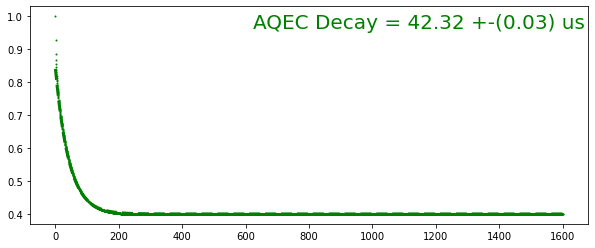

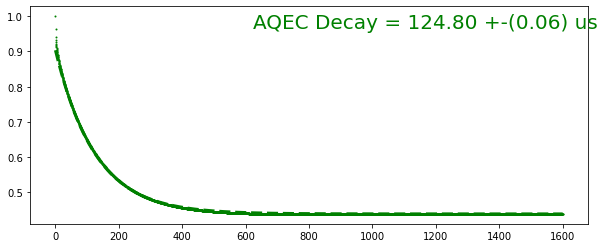

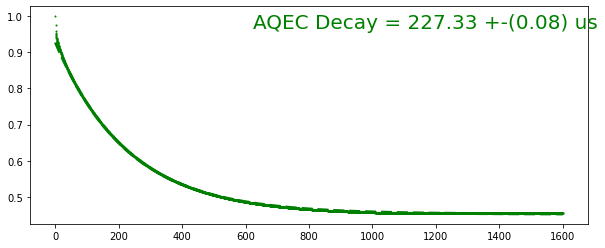

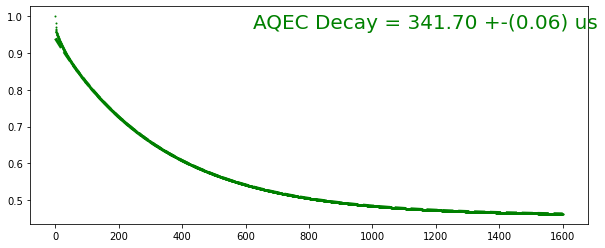

In [60]:
pi = np.pi
N_q = 3
N_r = 2
num = 2*pi
num1 = 1
delta1 = -116*num 
delta2 = -160*num 

Gamma_1r = 0.5*num
Gamma_2r = 0.5*num
n_th = 0.0
tlist = np.linspace(0,1600,4001)


Wr = 5*num
Wb = 5*num
Omega = 1.0*num
det1 = 2.5*num
det2 = -2.5*num
QRD = 0.0*num

# T1(in us) = 1/gxx
logic_T_1d_err = []
logic_T_1d = []

T_list = np.array([10,20,30,40])

for TT in T_list:
    print('calculating T1:',TT)
    circuit_param = {'delta1':delta1, 'delta2':delta2, 'Gamma_1p':1/TT,'Gamma_2p':1/TT, "n_th":0, "QRD":QRD,
                     'Gamma_1r':Gamma_1r, 'Gamma_2r':Gamma_2r, 'Wr':Wr, 'Wb':Wb, 'Omega':Omega, 'det1':det1, 'det2': det2}

    # important settings to improve ODE solver
    options = Options()
    options.num_cpus=24
    options.atol = 1e-17
    options.rtol = 1e-12
    options.order = 100
    options.nsteps = 200000

    # starting at Lx
    dims = [N_q,N_q,N_r,N_r]
    gf_fg = tensor(ket("0",N_q)*bra("2",N_q), ket("2",N_q)*bra("0",N_q), qeye(N_r), qeye(N_r))
    gg_ff = tensor(ket("0",N_q)*bra("2",N_q), ket("0",N_q)*bra("2",N_q), qeye(N_r), qeye(N_r))
    psi0 = 1*(ket('0000',dim=dims) - ket('2200',dim=dims)) + 1*(1*ket('2000',dim=dims) - 1*ket('0200',dim=dims)) 
    # psi0 = ket('1200',dim=dims)
    psi0 = psi0.unit()
    cops2, result1 = stabilizationc(circuit_param, tlist, psi0, options)
    lgffg = (ket('2000',dim=dims) - ket('0200',dim=dims)).unit()
    lggff = (ket('0000',dim=dims) - ket('2200',dim=dims)).unit()
    llx = ((ket('0000',dim=dims) - ket('2200',dim=dims)) + (1*ket('2000',dim=dims) - 1*ket('0200',dim=dims))).unit()

    p_gffg, p_ggff, p_x = compute_fidelity_abs(result1, [lgffg, lggff, llx])
    Logical_Z, Logical_X = compute_expectation_vals(result1, [trackzz, trackxp])
    p1_gffg, p1_ggff = compute_expectation_vals(result1, [gf_fg, gg_ff])
    from scipy.optimize import curve_fit
    def single_decay(x, a, Tfast, c0):
        return a*np.exp(-x/Tfast)+c0
    vfig1 = plt.figure(figsize=(10,4))
    guess = np.array([1, 50,0.0])
    pfit33, pcov3 = curve_fit(single_decay, tlist[60:-1], p_x[60:-1], guess)
    print(pfit33, np.sqrt(np.diag(pcov3)))
    plt.text(0.4, 0.9, "AQEC Decay = %.2f +-(%.2f) us"%(pfit33[1] , np.sqrt(np.diag(pcov3))[1]), transform=plt.axes().transAxes, fontsize=20, color='green')
    fit33 = single_decay(tlist, *pfit33)
    plt.plot(np.array(tlist),fit33, color='green', linewidth=3, linestyle='--', marker='o',markersize=0.,label=r'AQEC fit')
    plt.plot(tlist,p_x, color='green', linewidth=3, linestyle='', marker='o',markersize=1.,label=r'AQEC')
    logic_T_1d.append(pfit33[1])
    logic_T_1d_err.append(np.sqrt(np.diag(pcov3))[1])

In [61]:
logic_T_1d

[42.323277040946074, 124.79808407935165, 227.3342874069042, 341.69811192950544]

In [62]:
logic_T_1d_err

[0.026042713124951544,
 0.06017734229026959,
 0.07542511580882118,
 0.058308982343534065]

## L0 W=10MHz, det=5, Omega=1.0, kappa=0.5

calculating T1: 10
Calculating T_1p
10.0%. Run time:  61.44s. Est. time left: 00:00:09:11
20.0%. Run time: 122.71s. Est. time left: 00:00:08:10
30.0%. Run time: 183.92s. Est. time left: 00:00:07:08
40.0%. Run time: 245.18s. Est. time left: 00:00:06:07
50.0%. Run time: 306.31s. Est. time left: 00:00:05:06
60.0%. Run time: 367.45s. Est. time left: 00:00:04:04
70.0%. Run time: 428.81s. Est. time left: 00:00:03:03
80.0%. Run time: 490.35s. Est. time left: 00:00:02:02
90.0%. Run time: 552.14s. Est. time left: 00:00:01:01
Total run time: 613.89s


/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/numpy/lib/function_base.py:486: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[-0.132254   39.49105767 -0.31512474] [1.63668904e-06 4.11904514e-04 4.33561826e-08]
calculating T1: 20
Calculating T_1p
10.0%. Run time:  56.18s. Est. time left: 00:00:08:24
20.0%. Run time: 112.23s. Est. time left: 00:00:07:28
30.0%. Run time: 168.30s. Est. time left: 00:00:06:32
40.0%. Run time: 224.27s. Est. time left: 00:00:05:36
50.0%. Run time: 280.24s. Est. time left: 00:00:04:40
60.0%. Run time: 336.22s. Est. time left: 00:00:03:44
70.0%. Run time: 392.18s. Est. time left: 00:00:02:48
80.0%. Run time: 448.17s. Est. time left: 00:00:01:52
90.0%. Run time: 504.15s. Est. time left: 00:00:00:56
Total run time: 559.98s


/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/numpy/lib/function_base.py:486: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[-1.29314394e-01  1.39504166e+02 -3.39748040e-01] [5.62694426e-06 8.14443206e-03 7.38084347e-07]
calculating T1: 30
Calculating T_1p
10.0%. Run time:  65.05s. Est. time left: 00:00:09:44
20.0%. Run time: 129.91s. Est. time left: 00:00:08:39
30.0%. Run time: 194.74s. Est. time left: 00:00:07:34
40.0%. Run time: 259.59s. Est. time left: 00:00:06:29
50.0%. Run time: 324.46s. Est. time left: 00:00:05:24
60.0%. Run time: 389.30s. Est. time left: 00:00:04:19
70.0%. Run time: 454.15s. Est. time left: 00:00:03:14
80.0%. Run time: 518.99s. Est. time left: 00:00:02:09
90.0%. Run time: 583.90s. Est. time left: 00:00:01:04
Total run time: 648.67s


/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/numpy/lib/function_base.py:486: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[-1.29414582e-01  2.91137919e+02 -3.47799088e-01] [8.21834766e-06 3.48673778e-02 2.72292303e-06]
calculating T1: 40
Calculating T_1p
10.0%. Run time:  63.15s. Est. time left: 00:00:09:26
20.0%. Run time: 126.16s. Est. time left: 00:00:08:24
30.0%. Run time: 189.19s. Est. time left: 00:00:07:21
40.0%. Run time: 252.19s. Est. time left: 00:00:06:18
50.0%. Run time: 315.19s. Est. time left: 00:00:05:15
60.0%. Run time: 378.19s. Est. time left: 00:00:04:12
70.0%. Run time: 441.20s. Est. time left: 00:00:03:09
80.0%. Run time: 504.20s. Est. time left: 00:00:02:06
90.0%. Run time: 567.14s. Est. time left: 00:00:01:02
Total run time: 629.91s
[-1.30053195e-01  4.86552349e+02 -3.51463826e-01] [9.89030796e-06 1.08514158e-01 8.00438063e-06]


/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/numpy/lib/function_base.py:486: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


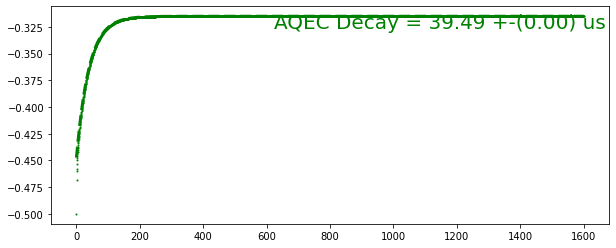

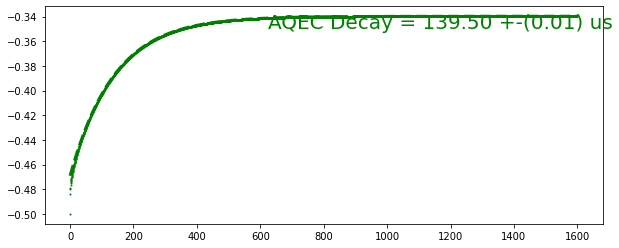

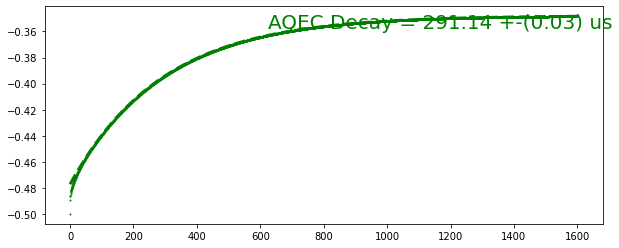

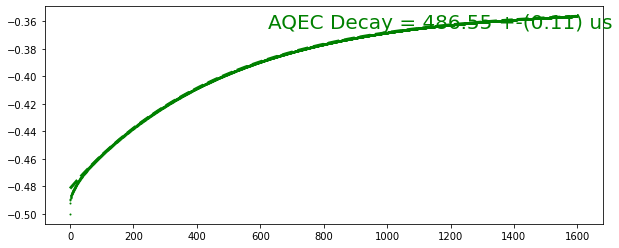

In [63]:
pi = np.pi
N_q = 3
N_r = 2
num = 2*pi
num1 = 1
delta1 = -116*num 
delta2 = -160*num 

Gamma_1r = 0.5*num
Gamma_2r = 0.5*num
n_th = 0.0
tlist = np.linspace(0,1600,4001)


Wr = 10*num
Wb = 10*num
Omega = 1.0*num
det1 = 5*num
det2 = -5*num
QRD = 0.0*num

# T1(in us) = 1/gxx
logic_T_1d_err = []
logic_T_1d = []

T_list = np.array([10,20,30,40])

for TT in T_list:
    print('calculating T1:',TT)
    circuit_param = {'delta1':delta1, 'delta2':delta2, 'Gamma_1p':1/TT,'Gamma_2p':1/TT, "n_th":0, "QRD":QRD,
                     'Gamma_1r':Gamma_1r, 'Gamma_2r':Gamma_2r, 'Wr':Wr, 'Wb':Wb, 'Omega':Omega, 'det1':det1, 'det2': det2}

    # important settings to improve ODE solver
    options = Options()
    options.num_cpus=24
    options.atol = 1e-17
    options.rtol = 1e-12
    options.order = 100
    options.nsteps = 200000

    # starting at Lx
    dims = [N_q,N_q,N_r,N_r]
    gf_fg = tensor(ket("0",N_q)*bra("2",N_q), ket("2",N_q)*bra("0",N_q), qeye(N_r), qeye(N_r))
    psi0 = 0*(ket('0000',dim=dims) - ket('2200',dim=dims)) + 1*(1*ket('2000',dim=dims) - 1*ket('0200',dim=dims)) 
    # psi0 = ket('1200',dim=dims)
    psi0 = psi0.unit()
    cops2, result1 = stabilizationc(circuit_param, tlist, psi0, options)
    lgffg = (ket('2000',dim=dims) - ket('0200',dim=dims)).unit()
    lggff = (ket('0000',dim=dims) - ket('2200',dim=dims)).unit()
    llx = ((ket('0000',dim=dims) - ket('2200',dim=dims)) + (1*ket('2000',dim=dims) - 1*ket('0200',dim=dims))).unit()

    p_gffg, p_ggff, p_x = compute_fidelity_abs(result1, [lgffg, lggff, llx])
    Logical_Z, Logical_X = compute_expectation_vals(result1, [trackzz, trackxp])
    p1_gffg = compute_expectation_vals(result1, [gf_fg])
    from scipy.optimize import curve_fit
    def single_decay(x, a, Tfast, c0):
        return a*np.exp(-x/Tfast)+c0
    vfig1 = plt.figure(figsize=(10,4))
    guess = np.array([1, 50,0.0])
    pfit33, pcov3 = curve_fit(single_decay, tlist[60:-1], p1_gffg[0][60:-1], guess)
    print(pfit33, np.sqrt(np.diag(pcov3)))
    plt.text(0.4, 0.9, "AQEC Decay = %.2f +-(%.2f) us"%(pfit33[1] , np.sqrt(np.diag(pcov3))[1]), transform=plt.axes().transAxes, fontsize=20, color='green')
    fit33 = single_decay(tlist, *pfit33)
    plt.plot(np.array(tlist),fit33, color='green', linewidth=3, linestyle='--', marker='o',markersize=0.,label=r'AQEC fit')
    plt.plot(tlist,p1_gffg[0], color='green', linewidth=3, linestyle='', marker='o',markersize=1.,label=r'AQEC')
    logic_T_1d.append(pfit33[1])
    logic_T_1d_err.append(np.sqrt(np.diag(pcov3))[1])

In [64]:
logic_T_1d

[39.49105767132675, 139.50416626799338, 291.1379191986886, 486.55234949995287]

In [65]:
logic_T_1d_err

[0.0004119045138664131,
 0.008144432061071417,
 0.034867377774074025,
 0.108514157952437]

calculating T1: 30
Calculating T_1p
10.0%. Run time:  97.95s. Est. time left: 00:00:14:39
20.0%. Run time: 195.89s. Est. time left: 00:00:13:02
30.0%. Run time: 293.84s. Est. time left: 00:00:11:25
40.0%. Run time: 391.73s. Est. time left: 00:00:09:47
50.0%. Run time: 489.66s. Est. time left: 00:00:08:09
60.0%. Run time: 587.55s. Est. time left: 00:00:06:31
70.0%. Run time: 685.43s. Est. time left: 00:00:04:53
80.0%. Run time: 783.34s. Est. time left: 00:00:03:15
90.0%. Run time: 881.52s. Est. time left: 00:00:01:37
Total run time: 979.69s


/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/numpy/lib/function_base.py:486: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[-1.29217549e-01  2.91825060e+02 -3.47766850e-01] [4.08885245e-06 1.39970914e-02 7.84915075e-07]
calculating T1: 40
Calculating T_1p
10.0%. Run time:  94.55s. Est. time left: 00:00:14:08
20.0%. Run time: 188.75s. Est. time left: 00:00:12:34
30.0%. Run time: 282.96s. Est. time left: 00:00:10:59
40.0%. Run time: 377.20s. Est. time left: 00:00:09:25
50.0%. Run time: 471.42s. Est. time left: 00:00:07:51
60.0%. Run time: 565.65s. Est. time left: 00:00:06:16
70.0%. Run time: 659.86s. Est. time left: 00:00:04:42
80.0%. Run time: 754.07s. Est. time left: 00:00:03:08
90.0%. Run time: 848.28s. Est. time left: 00:00:01:34
Total run time: 942.29s
[ 0.09511272  1.38283723 -0.37610159] [inf inf inf]


/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/numpy/lib/function_base.py:486: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


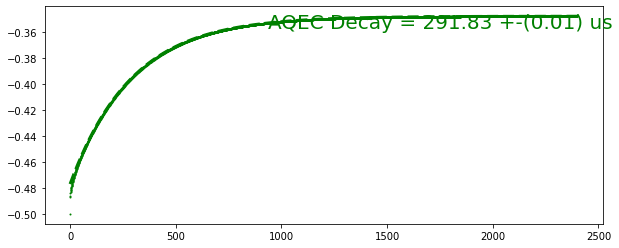

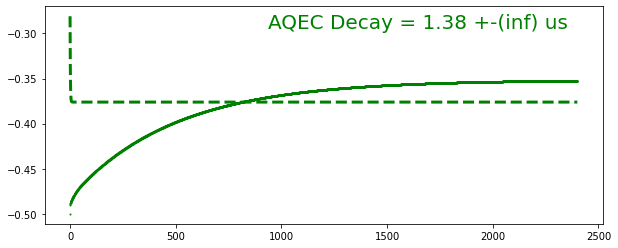

In [67]:
pi = np.pi
N_q = 3
N_r = 2
num = 2*pi
num1 = 1
delta1 = -116*num 
delta2 = -160*num 

Gamma_1r = 0.5*num
Gamma_2r = 0.5*num
n_th = 0.0
tlist = np.linspace(0,2400,4001)


Wr = 10*num
Wb = 10*num
Omega = 1.0*num
det1 = 5*num
det2 = -5*num
QRD = 0.0*num

# T1(in us) = 1/gxx
logic_T_1d_err = []
logic_T_1d = []

T_list = np.array([30,40])

for TT in T_list:
    print('calculating T1:',TT)
    circuit_param = {'delta1':delta1, 'delta2':delta2, 'Gamma_1p':1/TT,'Gamma_2p':1/TT, "n_th":0, "QRD":QRD,
                     'Gamma_1r':Gamma_1r, 'Gamma_2r':Gamma_2r, 'Wr':Wr, 'Wb':Wb, 'Omega':Omega, 'det1':det1, 'det2': det2}

    # important settings to improve ODE solver
    options = Options()
    options.num_cpus=24
    options.atol = 1e-17
    options.rtol = 1e-12
    options.order = 100
    options.nsteps = 200000

    # starting at Lx
    dims = [N_q,N_q,N_r,N_r]
    gf_fg = tensor(ket("0",N_q)*bra("2",N_q), ket("2",N_q)*bra("0",N_q), qeye(N_r), qeye(N_r))
    psi0 = 0*(ket('0000',dim=dims) - ket('2200',dim=dims)) + 1*(1*ket('2000',dim=dims) - 1*ket('0200',dim=dims)) 
    # psi0 = ket('1200',dim=dims)
    psi0 = psi0.unit()
    cops2, result1 = stabilizationc(circuit_param, tlist, psi0, options)
    lgffg = (ket('2000',dim=dims) - ket('0200',dim=dims)).unit()
    lggff = (ket('0000',dim=dims) - ket('2200',dim=dims)).unit()
    llx = ((ket('0000',dim=dims) - ket('2200',dim=dims)) + (1*ket('2000',dim=dims) - 1*ket('0200',dim=dims))).unit()

    p_gffg, p_ggff, p_x = compute_fidelity_abs(result1, [lgffg, lggff, llx])
    Logical_Z, Logical_X = compute_expectation_vals(result1, [trackzz, trackxp])
    p1_gffg = compute_expectation_vals(result1, [gf_fg])
    from scipy.optimize import curve_fit
    def single_decay(x, a, Tfast, c0):
        return a*np.exp(-x/Tfast)+c0
    vfig1 = plt.figure(figsize=(10,4))
    guess = np.array([1, 50,0.0])
    pfit33, pcov3 = curve_fit(single_decay, tlist[60:-1], p1_gffg[0][60:-1], guess)
    print(pfit33, np.sqrt(np.diag(pcov3)))
    plt.text(0.4, 0.9, "AQEC Decay = %.2f +-(%.2f) us"%(pfit33[1] , np.sqrt(np.diag(pcov3))[1]), transform=plt.axes().transAxes, fontsize=20, color='green')
    fit33 = single_decay(tlist, *pfit33)
    plt.plot(np.array(tlist),fit33, color='green', linewidth=3, linestyle='--', marker='o',markersize=0.,label=r'AQEC fit')
    plt.plot(tlist,p1_gffg[0], color='green', linewidth=3, linestyle='', marker='o',markersize=1.,label=r'AQEC')
    logic_T_1d.append(pfit33[1])
    logic_T_1d_err.append(np.sqrt(np.diag(pcov3))[1])

[-1.29927292e-01  4.88731374e+02 -3.51330704e-01] [5.67551910e-06 4.37630909e-02 2.25085405e-06]


/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/numpy/lib/function_base.py:486: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


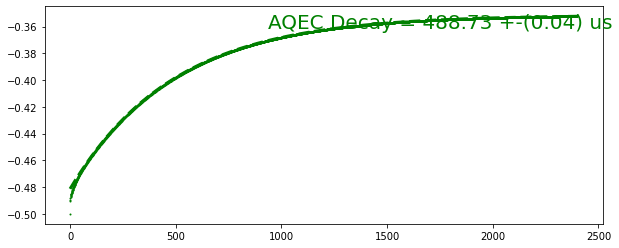

In [68]:
from scipy.optimize import curve_fit
def single_decay(x, a, Tfast, c0):
    return a*np.exp(-x/Tfast)+c0
vfig1 = plt.figure(figsize=(10,4))
guess = np.array([-1, 50,0.0])
pfit33, pcov3 = curve_fit(single_decay, tlist[60:-1], p1_gffg[0][60:-1], guess)
print(pfit33, np.sqrt(np.diag(pcov3)))
plt.text(0.4, 0.9, "AQEC Decay = %.2f +-(%.2f) us"%(pfit33[1] , np.sqrt(np.diag(pcov3))[1]), transform=plt.axes().transAxes, fontsize=20, color='green')
fit33 = single_decay(tlist, *pfit33)
plt.plot(np.array(tlist),fit33, color='green', linewidth=3, linestyle='--', marker='o',markersize=0.,label=r'AQEC fit')
plt.plot(tlist,p1_gffg[0], color='green', linewidth=3, linestyle='', marker='o',markersize=1.,label=r'AQEC')
logic_T_1d.append(pfit33[1])
logic_T_1d_err.append(np.sqrt(np.diag(pcov3))[1])

## L1 W=10MHz, det=5, Omega=1.0, kappa=0.5

calculating T1: 10
Calculating T_1p
10.0%. Run time:  76.72s. Est. time left: 00:00:11:28
20.0%. Run time: 153.23s. Est. time left: 00:00:10:12
30.0%. Run time: 229.60s. Est. time left: 00:00:08:55
40.0%. Run time: 306.18s. Est. time left: 00:00:07:38
50.0%. Run time: 383.10s. Est. time left: 00:00:06:22
60.0%. Run time: 459.54s. Est. time left: 00:00:05:06
70.0%. Run time: 536.13s. Est. time left: 00:00:03:49
80.0%. Run time: 613.10s. Est. time left: 00:00:02:33
90.0%. Run time: 690.18s. Est. time left: 00:00:01:16
Total run time: 767.17s


/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/numpy/lib/function_base.py:486: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[-0.32553058 39.4855619  -0.10209188] [5.07654089e-06 5.18950112e-04 1.34448293e-07]
calculating T1: 20
Calculating T_1p
10.0%. Run time:  71.32s. Est. time left: 00:00:10:40
20.0%. Run time: 142.24s. Est. time left: 00:00:09:28
30.0%. Run time: 213.15s. Est. time left: 00:00:08:16
40.0%. Run time: 284.03s. Est. time left: 00:00:07:05
50.0%. Run time: 354.90s. Est. time left: 00:00:05:54
60.0%. Run time: 425.85s. Est. time left: 00:00:04:43
70.0%. Run time: 496.78s. Est. time left: 00:00:03:32
80.0%. Run time: 567.71s. Est. time left: 00:00:02:21
90.0%. Run time: 638.63s. Est. time left: 00:00:01:10
Total run time: 709.39s


/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/numpy/lib/function_base.py:486: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[-3.46795034e-01  1.39548653e+02 -1.12303240e-01] [1.28326237e-05 6.92886051e-03 1.68384567e-06]
calculating T1: 30
Calculating T_1p
10.0%. Run time:  81.98s. Est. time left: 00:00:12:15
20.0%. Run time: 163.82s. Est. time left: 00:00:10:54
30.0%. Run time: 245.57s. Est. time left: 00:00:09:32
40.0%. Run time: 327.09s. Est. time left: 00:00:08:10
50.0%. Run time: 408.54s. Est. time left: 00:00:06:48
60.0%. Run time: 489.99s. Est. time left: 00:00:05:26
70.0%. Run time: 571.44s. Est. time left: 00:00:04:04
80.0%. Run time: 653.11s. Est. time left: 00:00:02:43
90.0%. Run time: 734.79s. Est. time left: 00:00:01:21
Total run time: 816.29s


/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/numpy/lib/function_base.py:486: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[-3.53825699e-01  2.91471595e+02 -1.17005742e-01] [1.57433382e-05 2.44775173e-02 5.22532353e-06]
calculating T1: 40
Calculating T_1p
10.0%. Run time:  79.28s. Est. time left: 00:00:11:51
20.0%. Run time: 158.24s. Est. time left: 00:00:10:32
30.0%. Run time: 237.34s. Est. time left: 00:00:09:13
40.0%. Run time: 316.40s. Est. time left: 00:00:07:54
50.0%. Run time: 395.43s. Est. time left: 00:00:06:35
60.0%. Run time: 474.47s. Est. time left: 00:00:05:16
70.0%. Run time: 553.54s. Est. time left: 00:00:03:57
80.0%. Run time: 632.59s. Est. time left: 00:00:02:38
90.0%. Run time: 711.60s. Est. time left: 00:00:01:19
Total run time: 790.40s
[-3.56791900e-01  4.87857498e+02 -1.20221678e-01] [1.67901250e-05 6.74817085e-02 1.36516978e-05]


/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/numpy/lib/function_base.py:486: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/home/ziqian/anaconda3/envs/Vstar/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


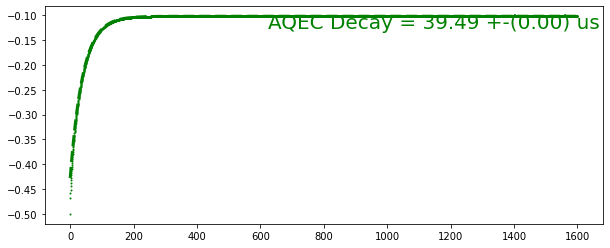

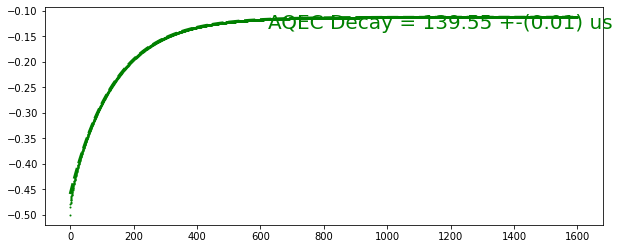

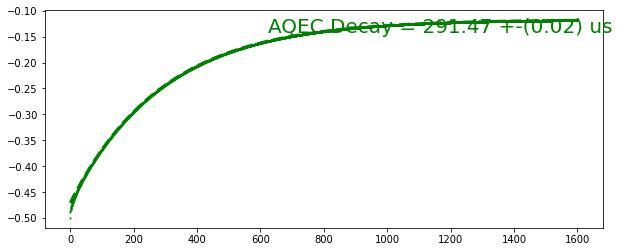

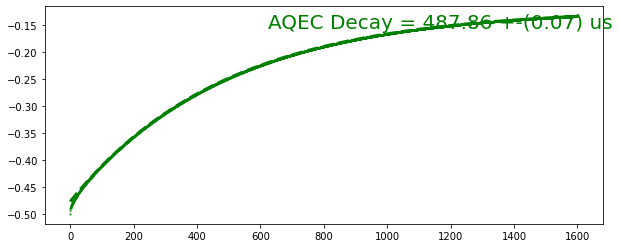

In [69]:
pi = np.pi
N_q = 3
N_r = 2
num = 2*pi
num1 = 1
delta1 = -116*num 
delta2 = -160*num 

Gamma_1r = 0.5*num
Gamma_2r = 0.5*num
n_th = 0.0
tlist = np.linspace(0,1600,4001)


Wr = 10*num
Wb = 10*num
Omega = 1.0*num
det1 = 5*num
det2 = -5*num
QRD = 0.0*num

# T1(in us) = 1/gxx
logic_T_1d_err = []
logic_T_1d = []

T_list = np.array([10,20,30,40])

for TT in T_list:
    print('calculating T1:',TT)
    circuit_param = {'delta1':delta1, 'delta2':delta2, 'Gamma_1p':1/TT,'Gamma_2p':1/TT, "n_th":0, "QRD":QRD,
                     'Gamma_1r':Gamma_1r, 'Gamma_2r':Gamma_2r, 'Wr':Wr, 'Wb':Wb, 'Omega':Omega, 'det1':det1, 'det2': det2}

    # important settings to improve ODE solver
    options = Options()
    options.num_cpus=24
    options.atol = 1e-17
    options.rtol = 1e-12
    options.order = 100
    options.nsteps = 200000

    # starting at Lx
    dims = [N_q,N_q,N_r,N_r]
    gf_fg = tensor(ket("0",N_q)*bra("2",N_q), ket("2",N_q)*bra("0",N_q), qeye(N_r), qeye(N_r))
    gg_ff = tensor(ket("0",N_q)*bra("2",N_q), ket("0",N_q)*bra("2",N_q), qeye(N_r), qeye(N_r))
    psi0 = 1*(ket('0000',dim=dims) - ket('2200',dim=dims)) + 0*(1*ket('2000',dim=dims) - 1*ket('0200',dim=dims)) 
    # psi0 = ket('1200',dim=dims)
    psi0 = psi0.unit()
    cops2, result1 = stabilizationc(circuit_param, tlist, psi0, options)
    lgffg = (ket('2000',dim=dims) - ket('0200',dim=dims)).unit()
    lggff = (ket('0000',dim=dims) - ket('2200',dim=dims)).unit()
    llx = ((ket('0000',dim=dims) - ket('2200',dim=dims)) + (1*ket('2000',dim=dims) - 1*ket('0200',dim=dims))).unit()

    p_gffg, p_ggff, p_x = compute_fidelity_abs(result1, [lgffg, lggff, llx])
    Logical_Z, Logical_X = compute_expectation_vals(result1, [trackzz, trackxp])
    p1_gffg, p1_ggff = compute_expectation_vals(result1, [gf_fg, gg_ff])
    from scipy.optimize import curve_fit
    def single_decay(x, a, Tfast, c0):
        return a*np.exp(-x/Tfast)+c0
    vfig1 = plt.figure(figsize=(10,4))
    guess = np.array([-1, 50,0.0])
    pfit33, pcov3 = curve_fit(single_decay, tlist[60:-1], p1_ggff[60:-1], guess)
    print(pfit33, np.sqrt(np.diag(pcov3)))
    plt.text(0.4, 0.9, "AQEC Decay = %.2f +-(%.2f) us"%(pfit33[1] , np.sqrt(np.diag(pcov3))[1]), transform=plt.axes().transAxes, fontsize=20, color='green')
    fit33 = single_decay(tlist, *pfit33)
    plt.plot(np.array(tlist),fit33, color='green', linewidth=3, linestyle='--', marker='o',markersize=0.,label=r'AQEC fit')
    plt.plot(tlist,p1_ggff, color='green', linewidth=3, linestyle='', marker='o',markersize=1.,label=r'AQEC')
    logic_T_1d.append(pfit33[1])
    logic_T_1d_err.append(np.sqrt(np.diag(pcov3))[1])

In [70]:
logic_T_1d

[39.485561902928715, 139.5486530413705, 291.4715949226381, 487.85749800416403]

In [71]:
logic_T_1d_err

[0.0005189501116056916,
 0.006928860510676558,
 0.02447751725805006,
 0.06748170851746377]

## Lx W=10MHz, det=5, Omega=1.0, kappa=0.5

calculating T1: 10
Calculating T_1p
10.0%. Run time:  74.50s. Est. time left: 00:00:11:08
20.0%. Run time: 148.74s. Est. time left: 00:00:09:54
30.0%. Run time: 222.95s. Est. time left: 00:00:08:39
40.0%. Run time: 297.10s. Est. time left: 00:00:07:25
50.0%. Run time: 371.21s. Est. time left: 00:00:06:11
60.0%. Run time: 445.43s. Est. time left: 00:00:04:56
70.0%. Run time: 519.66s. Est. time left: 00:00:03:42
80.0%. Run time: 593.84s. Est. time left: 00:00:02:28
90.0%. Run time: 668.02s. Est. time left: 00:00:01:14
Total run time: 742.03s
[ 0.42907637 55.27263843  0.408705  ] [4.77333157e-05 6.01270139e-03 2.08357059e-06]
calculating T1: 20
Calculating T_1p
10.0%. Run time:  68.37s. Est. time left: 00:00:10:13
20.0%. Run time: 136.56s. Est. time left: 00:00:09:05
30.0%. Run time: 204.74s. Est. time left: 00:00:07:57
40.0%. Run time: 272.94s. Est. time left: 00:00:06:49
50.0%. Run time: 341.14s. Est. time left: 00:00:05:40
60.0%. Run time: 409.24s. Est. time left: 00:00:04:32
70.0%. Ru

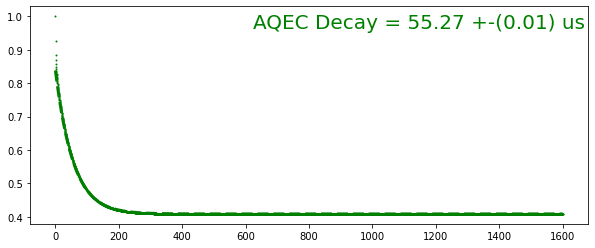

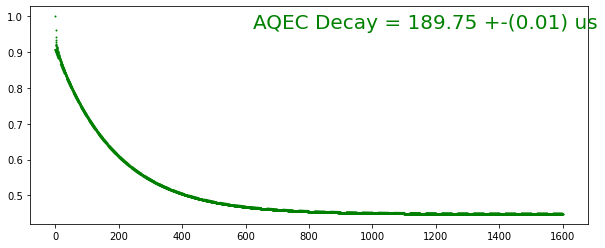

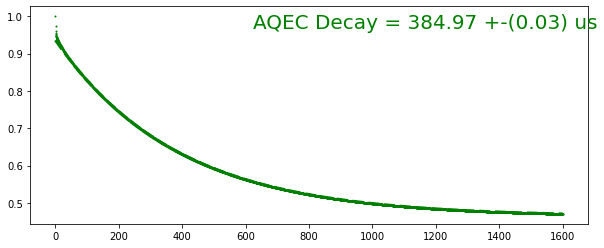

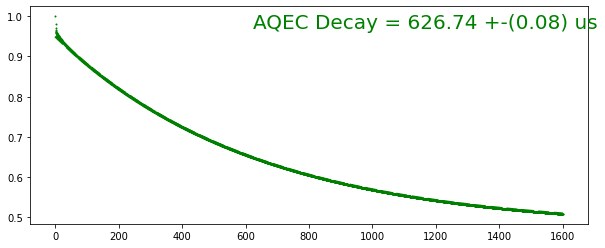

In [72]:
pi = np.pi
N_q = 3
N_r = 2
num = 2*pi
num1 = 1
delta1 = -116*num 
delta2 = -160*num 

Gamma_1r = 0.5*num
Gamma_2r = 0.5*num
n_th = 0.0
tlist = np.linspace(0,1600,4001)


Wr = 10*num
Wb = 10*num
Omega = 1.0*num
det1 = 5*num
det2 = -5*num
QRD = 0.0*num

# T1(in us) = 1/gxx
logic_T_1d_err = []
logic_T_1d = []

T_list = np.array([10,20,30,40])

for TT in T_list:
    print('calculating T1:',TT)
    circuit_param = {'delta1':delta1, 'delta2':delta2, 'Gamma_1p':1/TT,'Gamma_2p':1/TT, "n_th":0, "QRD":QRD,
                     'Gamma_1r':Gamma_1r, 'Gamma_2r':Gamma_2r, 'Wr':Wr, 'Wb':Wb, 'Omega':Omega, 'det1':det1, 'det2': det2}

    # important settings to improve ODE solver
    options = Options()
    options.num_cpus=24
    options.atol = 1e-17
    options.rtol = 1e-12
    options.order = 100
    options.nsteps = 200000

    # starting at Lx
    dims = [N_q,N_q,N_r,N_r]
    gf_fg = tensor(ket("0",N_q)*bra("2",N_q), ket("2",N_q)*bra("0",N_q), qeye(N_r), qeye(N_r))
    gg_ff = tensor(ket("0",N_q)*bra("2",N_q), ket("0",N_q)*bra("2",N_q), qeye(N_r), qeye(N_r))
    psi0 = 1*(ket('0000',dim=dims) - ket('2200',dim=dims)) + 1*(1*ket('2000',dim=dims) - 1*ket('0200',dim=dims)) 
    # psi0 = ket('1200',dim=dims)
    psi0 = psi0.unit()
    cops2, result1 = stabilizationc(circuit_param, tlist, psi0, options)
    lgffg = (ket('2000',dim=dims) - ket('0200',dim=dims)).unit()
    lggff = (ket('0000',dim=dims) - ket('2200',dim=dims)).unit()
    llx = ((ket('0000',dim=dims) - ket('2200',dim=dims)) + (1*ket('2000',dim=dims) - 1*ket('0200',dim=dims))).unit()

    p_gffg, p_ggff, p_x = compute_fidelity_abs(result1, [lgffg, lggff, llx])
    Logical_Z, Logical_X = compute_expectation_vals(result1, [trackzz, trackxp])
    p1_gffg, p1_ggff = compute_expectation_vals(result1, [gf_fg, gg_ff])
    from scipy.optimize import curve_fit
    def single_decay(x, a, Tfast, c0):
        return a*np.exp(-x/Tfast)+c0
    vfig1 = plt.figure(figsize=(10,4))
    guess = np.array([1, 50,0.0])
    pfit33, pcov3 = curve_fit(single_decay, tlist[60:-1], p_x[60:-1], guess)
    print(pfit33, np.sqrt(np.diag(pcov3)))
    plt.text(0.4, 0.9, "AQEC Decay = %.2f +-(%.2f) us"%(pfit33[1] , np.sqrt(np.diag(pcov3))[1]), transform=plt.axes().transAxes, fontsize=20, color='green')
    fit33 = single_decay(tlist, *pfit33)
    plt.plot(np.array(tlist),fit33, color='green', linewidth=3, linestyle='--', marker='o',markersize=0.,label=r'AQEC fit')
    plt.plot(tlist,p_x, color='green', linewidth=3, linestyle='', marker='o',markersize=1.,label=r'AQEC')
    logic_T_1d.append(pfit33[1])
    logic_T_1d_err.append(np.sqrt(np.diag(pcov3))[1])

In [73]:
logic_T_1d

[55.272638428282136, 189.7531011450943, 384.96946323576566, 626.7422824146034]

In [74]:
logic_T_1d_err

[0.006012701386744995,
 0.011829261165651663,
 0.02613849054113515,
 0.08028854082436558]

# Lifetime sweep for theory paper

## Sweep frequency detuning (Lx) W=5, Omega=1.0, Kappa=0.5, Tp=20us

In [33]:
pi = np.pi
N_q = 3
N_r = 2
num = 2*pi
num1 = 1
delta1 = -160*num 
delta2 = -260*num 

Gamma_1r = 0.5*num
Gamma_2r = 0.5*num
n_th = 0.0
tlist = np.linspace(0,200,2001)


Wr = 5*num
Wb = 5*num
Omega = 1.0*num
det1 = 1.25/2
det2 = 1.25/2
QRD = 0.0*num

# T1(in us) = 1/gxx
logic_T_2d_err = []
logic_T_2d = []

det_list1 = np.linspace(-7.5,7.5,16)*num
det_list2 = np.linspace(-7.5,7.5,16)*num
for det1 in det_list1:
    logic_T_1d_err= []
    logic_T_1d = []
    for det2 in det_list2:
        print('calculating detuning combination:', det1/num,' ', det2/num)
        circuit_param = {'delta1':delta1, 'delta2':delta2, 'Gamma_1p':1/20,'Gamma_2p':1/20, "n_th":0, "QRD":QRD,
                         'Gamma_1r':Gamma_1r, 'Gamma_2r':Gamma_2r, 'Wr':Wr, 'Wb':Wb, 'Omega':Omega, 'det1':det1, 'det2': det2}

        # important settings to improve ODE solver
        options = Options()
        options.num_cpus=24
        options.atol = 1e-17
        options.rtol = 1e-12
        options.order = 100
        options.nsteps = 200000

        # starting at Lx
        dims = [N_q,N_q,N_r,N_r]
        gf_fg = tensor(ket("0",N_q)*bra("2",N_q), ket("2",N_q)*bra("0",N_q), qeye(N_r), qeye(N_r))
        gg_ff = tensor(ket("0",N_q)*bra("2",N_q), ket("0",N_q)*bra("2",N_q), qeye(N_r), qeye(N_r))
        psi0 = 1*(ket('0000',dim=dims) - ket('2200',dim=dims)) + 1*(1*ket('2000',dim=dims) - 1*ket('0200',dim=dims)) 
        # psi0 = ket('1200',dim=dims)
        psi0 = psi0.unit()
        cops2, result1 = stabilizationc(circuit_param, tlist, psi0, options)
        lgffg = (ket('2000',dim=dims) - ket('0200',dim=dims)).unit()
        lggff = (ket('0000',dim=dims) - ket('2200',dim=dims)).unit()
        llx = ((ket('0000',dim=dims) - ket('2200',dim=dims)) + (1*ket('2000',dim=dims) - 1*ket('0200',dim=dims))).unit()

        p_gffg, p_ggff, p_x = compute_fidelity_abs(result1, [lgffg, lggff, llx])
        Logical_Z, Logical_X = compute_expectation_vals(result1, [trackzz, trackxp])
        p1_gffg, p1_ggff = compute_expectation_vals(result1, [gf_fg, gg_ff])
        from scipy.optimize import curve_fit
        def single_decay(x, a, Tfast, c0):
            return a*np.exp(-x/Tfast)+c0
        # vfig1 = plt.figure(figsize=(10,4))
        guess = np.array([1, 50,0.0])
        pfit33, pcov3 = curve_fit(single_decay, tlist[100:-1], p_x[100:-1], guess)
        print(pfit33, np.sqrt(np.diag(pcov3)))
        # plt.text(0.4, 0.9, "AQEC Decay = %.2f +-(%.2f) us"%(pfit33[1] , np.sqrt(np.diag(pcov3))[1]), transform=plt.axes().transAxes, fontsize=20, color='green')
        fit33 = single_decay(tlist, *pfit33)
        # plt.plot(np.array(tlist),fit33, color='green', linewidth=3, linestyle='--', marker='o',markersize=0.,label=r'AQEC fit')
        # plt.plot(tlist,p_x, color='green', linewidth=3, linestyle='', marker='o',markersize=1.,label=r'AQEC')
        logic_T_1d.append(pfit33[1])
        logic_T_1d_err.append(np.sqrt(np.diag(pcov3))[1])
    logic_T_2d.append(logic_T_1d)
    logic_T_2d_err.append(logic_T_1d_err)

calculating detuning combination: -7.499999999999999   -7.499999999999999
Calculating T_1p
10.0%. Run time:   9.30s. Est. time left: 00:00:01:23
20.0%. Run time:  18.52s. Est. time left: 00:00:01:13
30.0%. Run time:  27.75s. Est. time left: 00:00:01:04
40.0%. Run time:  36.96s. Est. time left: 00:00:00:55
50.0%. Run time:  46.17s. Est. time left: 00:00:00:46
60.0%. Run time:  55.37s. Est. time left: 00:00:00:36
70.0%. Run time:  64.57s. Est. time left: 00:00:00:27
80.0%. Run time:  73.77s. Est. time left: 00:00:00:18
90.0%. Run time:  82.97s. Est. time left: 00:00:00:09
Total run time:  92.14s
[ 0.66698649 13.5620438   0.44168553] [0.00412039 0.06694383 0.00016127]
calculating detuning combination: -7.499999999999999   -6.500000000000001
Calculating T_1p
10.0%. Run time:   9.32s. Est. time left: 00:00:01:23
20.0%. Run time:  18.55s. Est. time left: 00:00:01:14
30.0%. Run time:  27.78s. Est. time left: 00:00:01:04
40.0%. Run time:  37.01s. Est. time left: 00:00:00:55
50.0%. Run time:  4

In [38]:
ln75 = [13.5620438, 14.18197431, 31.80376432, 55.79793359, 70.40387402, 80.3386275, 85.91548736, 87.41083351, 85.40711807, 80.83130352, 74.89874132, 68.03598178, 61.39076724, 55.18250037, 49.58884572, 44.49825286]
ln65 = [13.85722963, 13.64732157, 14.14442833, 32.49302176, 60.54912445, 78.79081728, 90.86655727, 96.71199215, 96.87140587, 92.66950559, 85.78179272, 77.86702563, 69.6061539, 62.02068873, 55.24949696, 49.35507696]
ln55 = [29.45391621, 13.87941511, 13.72837264, 14.11197606, 33.10184484, 65.27212114, 87.47191776, 101.66303676, 107.21863156, 105.32298017, 98.45144154, 89.16355107, 79.45795344, 70.09666555, 61.87144425, 54.78735326]
ln45 = [52.78896189, 30.48256983, 13.90111286, 13.8028345, 14.08417517, 33.59566735, 69.59997666, 95.60927444, 111.42193981, 115.88683675, 111.36062626, 101.76080454, 90.41726245, 79.42114636, 69.42509896, 60.93525443 ]
ln35 = [69.65461765, 58.28781983, 31.44157668, 13.92237836, 13.86781107, 14.06025327, 33.94742245, 73.09185463, 102.0415695, 118.39154757, 120.93265994, 113.68705399, 101.90519054, 89.28500405, 77.72086758, 67.63931067]
ln25 = [80.41378045, 78.12633613, 63.57142726, 32.29600986, 13.94312036, 13.92023343, 14.03921263, 34.13442235, 75.30794144, 105.56834967, 120.95083056, 121.07262567, 111.70368116, 98.80588874, 85.92163531, 74.55785]
ln15 = [86.06706823, 90.94268564, 86.85246953, 68.33493289, 33.01505055, 13.96321469, 13.9572819, 14.01991741, 34.13907155, 75.93431879, 105.42346151, 118.42241091, 116.23890807, 105.84585373, 93.04932927, 80.8429795]
ln05 = [87.69557473, 97.03598445, 101.73324127, 95.06154669, 72.22522765, 33.57348994, 13.98257451, 13.97644784, 14.00130394, 33.95177552, 74.86246773, 101.6484093, 111.47727564, 107.62942841, 97.35677804, 85.62570575]
l05 = [85.62570791, 97.35678064, 107.62943223, 111.47727248, 101.64841277, 74.86247204, 33.95178477, 14.00130772, 13.97644807, 13.98257107, 33.57348113, 72.22522187, 95.06154158, 101.7332389, 97.03598156, 87.69556917]
l15 = [80.84298101, 93.04932961, 105.84585175, 116.23890962, 118.42240736, 105.4234628, 75.93432097, 34.13907924, 14.01992157, 13.95728224, 13.96321162, 33.01504234, 68.33492619, 86.85246358, 90.94268006, 86.06706159]
l25 = [74.55785002, 85.92163356, 98.80588476, 111.70367901, 121.07263068, 120.95082613, 105.56835211, 75.30794582, 34.13443104, 14.03921642, 13.92023376, 13.94311712, 32.2960008, 63.57141617, 78.12632967, 80.41377567]
l35 = [67.63930902, 77.72086349, 89.2849996, 101.90518593, 113.68704903, 120.932658, 118.39154612, 102.04156915, 73.09185513, 33.94743062, 14.06025775, 13.86781171, 13.92237499, 31.44156804, 58.28780841, 69.654611 ]
l45 = [60.93525013, 69.42509419, 79.42114203, 90.41726241, 101.76079735, 111.36062146, 115.88683793, 111.42193074, 95.60926868, 69.59997677, 33.59567442, 14.08417966, 13.80283554, 13.9011101, 30.48256183, 52.78894958]
l55 = [54.78734873, 61.87143869, 70.09666053, 79.45795148, 89.16354534, 98.45143676, 105.32296849, 107.21862595, 101.66302531, 87.47191444, 65.27212185, 33.10185311, 14.1119803, 13.72837374, 13.87941246, 29.45390779]
l65 = [49.35507289, 55.24949045, 62.02068456, 69.6061487, 77.86701833, 85.78178275, 92.66949528, 96.87139679, 96.71198957, 90.8665523, 78.79081142, 60.54912369, 32.49302932, 14.14443327, 13.64732253, 13.85722727]
l75 = [44.49824701, 49.58883881, 55.18249415, 61.39076237, 68.03597666, 74.89873497, 80.83129492, 85.40710974, 87.41082356, 85.915477, 80.33862127, 70.40386683, 55.79793261, 31.80377156, 14.18197955, 13.56204484   ]
logic_T_2d = []
logic_T_2d.append(ln75)
logic_T_2d.append(ln65)
logic_T_2d.append(ln55)
logic_T_2d.append(ln45)
logic_T_2d.append(ln35)
logic_T_2d.append(ln25)
logic_T_2d.append(ln15)
logic_T_2d.append(ln05)
logic_T_2d.append(l05)
logic_T_2d.append(l15)
logic_T_2d.append(l25)
logic_T_2d.append(l35)
logic_T_2d.append(l45)
logic_T_2d.append(l55)
logic_T_2d.append(l65)
logic_T_2d.append(l75)
logic_T_2d = np.array(logic_T_2d)

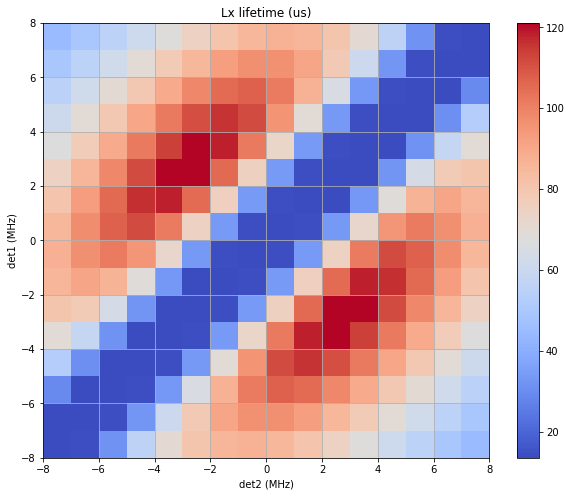

In [43]:
import matplotlib.colors as colors
# levels = [30,50,70,100,120]
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)
plt.pcolormesh(det_list2/num, det_list1/num, logic_T_2d, cmap='coolwarm', norm=colors.Normalize(vmin=logic_T_2d.min(), vmax=logic_T_2d.max()),label='Infidelity',shading='nearest')
# plt.pcolormesh(Omega_list/2/pi, Gamma_list/2/pi, infidelity, cmap='coolwarm',label='Infidelity')
# CS = ax.contour(det_list2/num, det_list1/num, logic_T_2d,levels)
# ax.clabel(CS, inline=True)
cbar = plt.colorbar()
ax.set_xlabel('det2 (MHz)')
ax.set_ylabel('det1 (MHz)')
ax.set_title('Lx lifetime (us)')
plt.grid()

## Sweep W Omega ratio (Lx), det=W/sqrt(3), Omega = sqrt(2)*Kappa

In [48]:
pi = np.pi
N_q = 3
N_r = 2
num = 2*pi
num1 = 1
delta1 = -160*num 
delta2 = -260*num 

Gamma_1r = 0.5*num
Gamma_2r = 0.5*num
n_th = 0.0
tlist = np.linspace(0,200,2001)


Wr = 5*num
Wb = 5*num
Omega = 0.5*num*sqrt(2)
det1 = Wr/sqrt(3)
det2 = Wr/sqrt(3)
QRD = 0.0*num

# T1(in us) = 1/gxx
logic_T_2d_err = []
logic_T_2d = []

W_list = np.linspace(1,15,15)*num
Omega_list = np.linspace(0.1,1.5,15)*num
for W in W_list:
    Wr = W
    Wb = W
    logic_T_1d_err= []
    logic_T_1d = []
    for Omega in Omega_list:
        det1 = Wr/sqrt(3)
        det2 = -Wr/sqrt(3)
        Gamma_1r = Omega
        Gamma_2r = Omega
        print('calculating W, Omega combination:', W/num,' ', Omega/num)
        circuit_param = {'delta1':delta1, 'delta2':delta2, 'Gamma_1p':1/20,'Gamma_2p':1/20, "n_th":0, "QRD":QRD,
                         'Gamma_1r':Gamma_1r, 'Gamma_2r':Gamma_2r, 'Wr':Wr, 'Wb':Wb, 'Omega':Omega, 'det1':det1, 'det2': det2}

        # important settings to improve ODE solver
        options = Options()
        options.num_cpus=24
        options.atol = 1e-17
        options.rtol = 1e-12
        options.order = 100
        options.nsteps = 200000

        # starting at Lx
        dims = [N_q,N_q,N_r,N_r]
        gf_fg = tensor(ket("0",N_q)*bra("2",N_q), ket("2",N_q)*bra("0",N_q), qeye(N_r), qeye(N_r))
        gg_ff = tensor(ket("0",N_q)*bra("2",N_q), ket("0",N_q)*bra("2",N_q), qeye(N_r), qeye(N_r))
        psi0 = 1*(ket('0000',dim=dims) - ket('2200',dim=dims)) + 1*(1*ket('2000',dim=dims) - 1*ket('0200',dim=dims)) 
        # psi0 = ket('1200',dim=dims)
        psi0 = psi0.unit()
        cops2, result1 = stabilizationc(circuit_param, tlist, psi0, options)
        lgffg = (ket('2000',dim=dims) - ket('0200',dim=dims)).unit()
        lggff = (ket('0000',dim=dims) - ket('2200',dim=dims)).unit()
        llx = ((ket('0000',dim=dims) - ket('2200',dim=dims)) + (1*ket('2000',dim=dims) - 1*ket('0200',dim=dims))).unit()

        p_gffg, p_ggff, p_x = compute_fidelity_abs(result1, [lgffg, lggff, llx])
        Logical_Z, Logical_X = compute_expectation_vals(result1, [trackzz, trackxp])
        p1_gffg, p1_ggff = compute_expectation_vals(result1, [gf_fg, gg_ff])
        from scipy.optimize import curve_fit
        def single_decay(x, a, Tfast, c0):
            return a*np.exp(-x/Tfast)+c0
        # vfig1 = plt.figure(figsize=(10,4))
        guess = np.array([1, 50,0.0])
        pfit33, pcov3 = curve_fit(single_decay, tlist[100:-1], p_x[100:-1], guess)
        print(pfit33, np.sqrt(np.diag(pcov3)))
        # plt.text(0.4, 0.9, "AQEC Decay = %.2f +-(%.2f) us"%(pfit33[1] , np.sqrt(np.diag(pcov3))[1]), transform=plt.axes().transAxes, fontsize=20, color='green')
        fit33 = single_decay(tlist, *pfit33)
        # plt.plot(np.array(tlist),fit33, color='green', linewidth=3, linestyle='--', marker='o',markersize=0.,label=r'AQEC fit')
        # plt.plot(tlist,p_x, color='green', linewidth=3, linestyle='', marker='o',markersize=1.,label=r'AQEC')
        logic_T_1d.append(pfit33[1])
        logic_T_1d_err.append(np.sqrt(np.diag(pcov3))[1])
    logic_T_2d.append(logic_T_1d)
    logic_T_2d_err.append(logic_T_1d_err)

calculating W, Omega combination: 1.0   0.1
Calculating T_1p
10.0%. Run time:   7.53s. Est. time left: 00:00:01:07
20.0%. Run time:  14.10s. Est. time left: 00:00:00:56
30.0%. Run time:  20.68s. Est. time left: 00:00:00:48
40.0%. Run time:  27.25s. Est. time left: 00:00:00:40
50.0%. Run time:  33.82s. Est. time left: 00:00:00:33
60.0%. Run time:  40.40s. Est. time left: 00:00:00:26
70.0%. Run time:  46.98s. Est. time left: 00:00:00:20
80.0%. Run time:  53.55s. Est. time left: 00:00:00:13
90.0%. Run time:  60.11s. Est. time left: 00:00:00:06
Total run time:  66.65s
[ 0.37741105 30.82819663  0.254091  ] [4.33979469e-04 4.77916793e-02 7.33169757e-05]
calculating W, Omega combination: 1.0   0.2
Calculating T_1p
10.0%. Run time:   7.76s. Est. time left: 00:00:01:09
20.0%. Run time:  14.84s. Est. time left: 00:00:00:59
30.0%. Run time:  21.90s. Est. time left: 00:00:00:51
40.0%. Run time:  28.95s. Est. time left: 00:00:00:43
50.0%. Run time:  36.00s. Est. time left: 00:00:00:35
60.0%. Run ti

In [51]:
print(logic_T_2d_err)

[[0.047791679292051796, 0.05823256866291746, 0.053774748035723983, 0.04168221093098294, 0.030232765678692094, 0.02476886512234494, 0.022255941260171712, 0.020908610014873028, 0.019914643206214666, 0.018945229529270878, 0.01791155895359433, 0.016840850924595772, 0.015807164817316765, 0.014888567424571807, 0.014135243693000073], [0.0505666703986911, 0.06691756521721069, 0.07665595459538808, 0.07863131186870233, 0.07372200461562788, 0.06558540682525091, 0.05687262425124157, 0.0484736379798516, 0.03981824266953512, 0.03334869199607013, 0.029374306403231444, 0.026815300825179345, 0.02506040987389897, 0.023808087302027315, 0.02287067555978771], [0.051103975702738856, 0.06883060395384537, 0.08381251793246444, 0.094742229601428, 0.09883221813492132, 0.09634571732126217, 0.089602550456456, 0.08111309843141037, 0.07253651151376869, 0.06462134953473557, 0.05752656288898534, 0.05114382553944474, 0.04496166451820096, 0.03901969717972322, 0.03457441635974337], [0.05129761950951348, 0.069533833352665

In [50]:
print(logic_T_2d)

[[30.828196625884612, 43.7812682669412, 43.52395318109671, 37.297877727728064, 30.725225903617538, 25.86062568447208, 22.635669067959274, 20.5582861858604, 19.233781732406648, 18.398375541747658, 17.878819759201345, 17.558646193998474, 17.35841366759777, 17.225102725090153, 17.125550905157507], [31.61779227193002, 50.71638851197505, 62.30233884458034, 65.38514231507851, 62.175099667562584, 56.07389407799886, 49.47002535945615, 43.423459470187225, 38.1307810837722, 33.68993340987489, 30.133491809132096, 27.338367759163184, 25.15146400128306, 23.43847887443038, 22.092955508251052], [31.76793809144353, 52.32218303585413, 68.39474461601276, 78.52007747305396, 82.19427193259165, 80.57956282365666, 75.67332089089608, 69.30383531441394, 62.69195510600692, 56.48264524128003, 50.93311120747626, 46.08117820054686, 41.837689048398566, 38.0997077022218, 34.874812722805196], [31.82059338060101, 52.91416250713936, 70.87909656277023, 84.7474348353384, 93.49205691411083, 96.97418463530273, 96.01481367